In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim import lr_scheduler
from tqdm import tqdm
from datetime import datetime, timedelta

C:\Users\jerryhuang\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
productInfo = pd.read_csv(r'./data/product_info_simple_final_train.csv')
cbYield = pd.read_csv("./data/cbyieldcurve_info_final.csv")
timeInfo = pd.read_csv("./data/time_info_final.csv")

In [6]:
cbYield['enddate'] = pd.to_datetime(cbYield['enddate'], format="%Y%m%d")
productInfo['transaction_date'] = pd.to_datetime(productInfo['transaction_date'], format="%Y%m%d")
timeInfo['stat_date'] = pd.to_datetime(timeInfo['stat_date'], format="%Y%m%d")
timeInfo['next_trade_date'] = pd.to_datetime(timeInfo['next_trade_date'], format="%Y%m%d")
timeInfo['last_trade_date'] = pd.to_datetime(timeInfo['last_trade_date'], format="%Y%m%d")

In [7]:
holidays = ["20210101", "20210211", "20210403", "20210501", "20210612", "20210919", "20210101", \
            "20220101", "20220129", "20220403", "20220430", "20220603", "20220910", "20220101"]

def is_within_last_week(date, string_dates):
    string_dates = pd.to_datetime(string_dates, format="%Y%m%d")
    for s_date in string_dates:
        if date >= s_date - timedelta(days=7) and date < s_date:
            return 1
    return 0

In [8]:
timeInfo['is_holiday'] = timeInfo['stat_date'].apply(lambda x: is_within_last_week(x, holidays))

In [9]:
df = productInfo.copy()

df = df.merge(cbYield[['enddate', 'yield']], left_on='transaction_date', right_on='enddate', how='left')

df = df.merge(timeInfo[['stat_date', 'is_week_end', 'is_month_end', 'is_quarter_end', 'is_year_end', 'is_holiday']], 
              left_on='transaction_date', right_on='stat_date', how='left')

df.drop(columns=["enddate", "stat_date"], inplace=True)

In [10]:
grouped = df.groupby('product_pid')
samples = []

for _, group in grouped:
    
    product_samples = group.values
    
    num_samples = len(product_samples)
    
    if num_samples < 40:
        continue
        
    for i in range(num_samples - 39):
        sample = product_samples[i: i + 40, :]
        column_1 = sample[-10:, 3]
        column_2 = sample[-10:, 2]
        
        are_elements_same = not (np.all(column_2 != column_2[0]) or np.all(column_1 != column_1[0]))
        if are_elements_same and np.count_nonzero(column_1)  == column_1.size and np.count_nonzero(column_2) == column_2.size:
            samples.append(sample)

In [11]:
final_array = np.array(samples)
train_data = final_array[:, :-10, 2:].astype(np.float32)
train_label = final_array[:, -10:, 2: 4].astype(np.float32)

In [12]:
mean_values = np.mean(train_label, axis=1)
mean_broadcasted = np.tile(mean_values[:, np.newaxis, :], (1, 10, 1))
train_label = (train_label - mean_broadcasted) / mean_broadcasted

In [13]:
DATA = torch.tensor(train_data, dtype=torch.float32)
LABEL = torch.tensor(train_label, dtype=torch.float32)

In [14]:
batch_size = 256
learning_rate = 0.001
N = DATA.shape[0]
num_epochs = 100
k = 5
cl_splits = KFold(n_splits=k, shuffle=True, random_state=666)

In [15]:
class model1(nn.Module):

    def __init__(self,
                 fc1_size=100,
                 fc2_size=100,
                 fc3_size=100,
#                  fc4_size=100,
#                  fc5_size=64,
                 fc1_dropout=0,
                 fc2_dropout=0,
                 fc3_dropout=0,
#                  fc4_dropout=0.2,
#                  fc5_dropout=0.2,
                 num_of_classes=50):
        super(model1, self).__init__()

        self.f_model = nn.Sequential(
            nn.Linear(339, fc1_size),  
            nn.BatchNorm1d(fc1_size),
            nn.ReLU(),
            nn.Dropout(fc1_dropout),
            nn.Linear(fc1_size, fc2_size),
            nn.BatchNorm1d(fc2_size),
            nn.ReLU(),
            nn.Dropout(fc2_dropout),
            nn.Linear(fc2_size, fc3_size),
            nn.BatchNorm1d(fc3_size),
            nn.ReLU(),
            nn.Dropout(fc3_dropout),
#             nn.Linear(fc3_size, fc4_size),
#             nn.BatchNorm1d(fc4_size),
#             nn.ReLU(),
#             nn.Dropout(fc4_dropout),
#             nn.Linear(fc4_size, fc5_size),
#             nn.BatchNorm1d(fc5_size),
#             nn.ReLU(),
#             nn.Dropout(fc5_dropout),
            nn.Linear(fc3_size, 20),
        )

        self.conv_layers1 = nn.Sequential(
            nn.Conv1d(6, 1, kernel_size=1),
            nn.BatchNorm1d(1),
            nn.Dropout(fc3_dropout),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        
        self.conv_layers2 = nn.Sequential(
            nn.Conv1d(5, 1, kernel_size=1),
            nn.BatchNorm1d(1),
            nn.Dropout(fc3_dropout),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        self.conv_2D = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=2), 
            nn.BatchNorm2d(1),
            nn.Dropout(fc3_dropout),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), 
        )
            
        hidden_dim = 1
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=64, batch_first=True,
                            dropout=fc3_dropout,
                            bidirectional=True)


        # for name, module in self.named_modules():
        #     if isinstance(module, nn.Linear):
        #         print('Linear初始化')
        #         nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        #     if isinstance(module, nn.Conv2d):
        #         print('Conv2d初始化')
        #         nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        #     if isinstance(module, nn.Conv1d):
        #         print('Conv1d初始化')
        #         nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')



    def forward(self, x):
        with torch.no_grad(): # 不计算梯度
            NN = torch.narrow(x, dim=-1, start=8, length=1)[:, -1:, ].squeeze(1).long() # during_days batch_size * 1
            # NN = torch.reshape(NN, (NN.shape[0], NN.shape[1] * NN.shape[2]))

            # min_vals, _ = torch.min(x, dim=1, keepdim=True)
            # max_vals, _ = torch.max(x, dim=1, keepdim=True)
            # x = (x - min_vals) / (max_vals - min_vals )

            # close_prices = torch.narrow(x, dim=-1, start=1, length=1)[:, -10:, ].transpose(1, 2).squeeze(1)
            # ma_window = 5
            # ma10 = close_prices.unfold(1, ma_window, 1).mean(dim=-1)
            
            # close_prices11 = torch.narrow(x, dim=-1, start=0, length=1)[:, -10:, ].transpose(1, 2).squeeze(1)
            # ma1110 = close_prices11.unfold(1, ma_window, 1).mean(dim=-1)

            end = torch.narrow(x, dim=-1, start=0, length=2)[:, -10:, ].squeeze(1) # batch_size * 10 * 2
            end = torch.reshape(end, (end.shape[0], end.shape[1] * end.shape[2])) # batch_size * 20 倒数十行的apply_amt和redeem_amt
            YDD = torch.narrow(x, dim=-1, start=7, length=1)[:, -10:, ].squeeze(1) # batch_size * 10 * 1
            YDD = torch.reshape(YDD, (YDD.shape[0], YDD.shape[1] * YDD.shape[2])) # batch_size * 10 倒数十行的uv_termmarket
            cbYDD = torch.narrow(x, dim=-1, start=10, length=1)[:, -10:, ].squeeze(1) # batch_size * 10 * 1
            cbYDD = torch.reshape(cbYDD, (cbYDD.shape[0], cbYDD.shape[1] * cbYDD.shape[2])) # batch_size * 10 倒数十行的cbyield
        apply = torch.narrow(x, dim=-1, start=0, length=1)[:, -30:, ].squeeze(1) # batch_size * 30 * 1  60行的apply_amt
        redeem = torch.narrow(x, dim=-1, start=1, length=1)[:, -30:, ].squeeze(1) # batch_size * 30 * 1  60行的redeem_amt
        cbYD = torch.narrow(x, dim=-1, start=10, length=1)[:, -30:, ].squeeze(1) # batch_size * 30 * 1  60行的cbyield
        apply, _ = self.lstm(apply) # batch_size * 30 * 2
        redeem, _ = self.lstm(redeem) # batch_size * 30 * 2
        cbYD, _ = self.lstm(cbYD) # batch_size * 30 * 2
        apply = torch.reshape(apply, (apply.shape[0], apply.shape[1] * apply.shape[2])) # batch_size * 60
        redeem = torch.reshape(redeem, (redeem.shape[0], redeem.shape[1] * redeem.shape[2])) # batch_size * 60
        cbYD = torch.reshape(cbYD, (cbYD.shape[0], cbYD.shape[1] * cbYD.shape[2])) # batch_size * 60
        YD =  torch.narrow(x, dim=-1, start=7, length=1)[:, -60:, ].squeeze(1) # batch_size * 30 * 1  60行的uv_termmarket
        YD, _ = self.lstm(YD)  # batch_size * 30 * 2
        YD = torch.reshape(YD, (YD.shape[0], YD.shape[1] * YD.shape[2]))  # batch_size * 60
        time = torch.narrow(x, dim=-1, start=11, length=5)[:, -30:, ].squeeze(1) # batch_size * 30 * 5
        x = torch.narrow(x, dim=-1, start=2, length=6)[:, -30:, ].squeeze(1) # batch_size * 30 * 6
        min_vals, _ = torch.min(x, dim=1, keepdim=True)
        max_vals, _ = torch.max(x, dim=1, keepdim=True)
        x = (x - min_vals) / (max_vals - min_vals +1)

        xx = x.unsqueeze(1)  # batch_size * 1 * 30 * 6
        xx = self.conv_2D(xx) # batch_size * 1 * 14 * 2
        xx = torch.reshape(xx, (xx.shape[0], xx.shape[1] * xx.shape[2] * xx.shape[3])) # batch_size * 28
        
#         timex = time.unsqueeze(1) # batch_size * 1 * 30 * 5
#         timex = self.conv_2D(timex) # batch_size * 1 * 14 * 2
#         timex = torch.reshape(timex, (timex.shape[0], timex.shape[1] * timex.shape[2] * timex.shape[3])) # batch_size * 28
        
        x = x.transpose(1, 2) # batch_size * 6 * 30
        x = self.conv_layers1(x) # batch_size * 1 * 15
#         time = time.transpose(1, 2) # batch_size * 5 * 30
#         time = self.conv_layers2(time) # batch_size * 1 * 15
        out = x.transpose(1, 2) # batch_size * 15 * 1
        out2, _ = self.lstm(out) # batch_size * 15 * 2
        out2 = torch.reshape(out2, (out2.shape[0], out2.shape[1] * out2.shape[2])) # batch_size * 30
#         time_out = time.transpose(1, 2) # batch_size * 15 * 1
#         time_out2, _ = self.lstm(time_out) # batch_size * 15 * 2
#         time_out2 = torch.reshape(time_out2, (time_out2.shape[0], time_out2.shape[1] * time_out2.shape[2])) # batch_size * 30

        IN = torch.cat((xx,  # 28
                        # timex,  # 28
                        out2, # 30
                        # time_out2,  # 30
                        apply, # 60
                        redeem, # 60
                        end, # 20
                        NN, # 1
                        cbYD, # 60
                        cbYDD, # 10
                        YD, # 60
                        YDD # 10
                       ), dim=1) # batch_size 
        out = self.f_model(IN)
        out = torch.reshape(out, (out.shape[0], 10, 2))
        return out

In [16]:
L5 = []
L5_v = []
T_AUC = []
Fprs = []
Tprs = []
for fold, (train_idx, test_idx) in enumerate(cl_splits.split(np.arange(N))):
    DATA_t = DATA[train_idx]
    DATA_v = DATA[test_idx]
    LABEL_t = LABEL[train_idx]
    LABEL_v = LABEL[test_idx]

    print(DATA_v.shape, DATA_t.shape)

    dataset_train = TensorDataset(DATA_t, LABEL_t)
    dataset_val = TensorDataset(DATA_v, LABEL_v)
    print('Fold {}'.format(fold + 1))
    train_loader = DataLoader(dataset_train, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(dataset_val, shuffle=True, batch_size=batch_size)

    model = model1()
    model.to(device)
    criterion = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), weight_decay=1e-5)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)
    L_train = []
    L_val = []
    AUC = []
    fp = []
    tp = []
    min_validation_loss = 9999
    for epoch in range(num_epochs):
        print(f"In epoch {epoch}:")
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        train_running_loss = 0.0
        ACC = 0
        counter = 0
        model.train()
        for X, y in tqdm(train_loader):
            optimizer.zero_grad()
            counter += 1
            output = model(X.to(device))
            loss = criterion(output, y.to(device))
            train_running_loss += loss.item()
            loss.backward()
            optimizer.step()
        scheduler.step()
        TL = train_running_loss / counter
        L_train.append(TL)
        model.eval()
        PREDICT = []
        TRUE = []
        ACC = 0
        counter = 0
        with torch.no_grad():
            current_test_loss = 0.0

            for XX, Z in tqdm(val_loader):
                counter += 1
                output = model(XX.to(device))
                loss = criterion(output, Z.to(device))
                current_test_loss += loss.item()
                PREDICT.extend(output.cpu().numpy())
                TRUE.extend(Z.cpu().numpy())
            T_loss = current_test_loss / counter
            L_val.append(T_loss)
            if min_validation_loss > T_loss:
                min_validation_loss = T_loss
                best_epoch = epoch
                print('Min validation_loss ' + str(min_validation_loss) + ' in epoch ' + str(best_epoch))
                torch.save(model.state_dict(), fr"./weights/model_1_{fold}.pt")
        PP = np.array(PREDICT)
        TT = np.array(TRUE)
        flattened_array1 = PP.flatten()
        flattened_array2 = TT.flatten()
        correlation_matrix = np.corrcoef(flattened_array1, flattened_array2)
        correlation_value = correlation_matrix[0, 1]

        print("Train loss: ", TL, "Val loss: ", T_loss,'correlation_value',correlation_value)
        # AUC.append()
    L5.append(L_train)
    L5_v.append(L_val)
    # T_AUC.append(AUC)

torch.Size([5499, 30, 16]) torch.Size([21992, 30, 16])
Fold 1
In epoch 0:


100%|██████████| 22/22 [00:04<00:00,  4.67it/s]


Min validation_loss 0.4568111151456833 in epoch 0
Train loss:  0.4489931308252867 Val loss:  0.4568111151456833 correlation_value -0.001473080894126735
In epoch 1:


100%|██████████| 22/22 [00:04<00:00,  5.04it/s]


Train loss:  0.42591118708599446 Val loss:  0.46001759306951 correlation_value 0.0017654840397927929
In epoch 2:


100%|██████████| 22/22 [00:04<00:00,  5.00it/s]


Min validation_loss 0.45672115548090503 in epoch 2
Train loss:  0.42251773940962417 Val loss:  0.45672115548090503 correlation_value 0.0039048279156433
In epoch 3:


100%|██████████| 22/22 [00:04<00:00,  5.00it/s]


Min validation_loss 0.45564777742732654 in epoch 3
Train loss:  0.42049229768819585 Val loss:  0.45564777742732654 correlation_value 0.006294813649598238
In epoch 4:


100%|██████████| 22/22 [00:04<00:00,  5.37it/s]


Train loss:  0.41935375228870747 Val loss:  0.45711771737445483 correlation_value 0.00842632015415165
In epoch 5:


100%|██████████| 22/22 [00:05<00:00,  4.38it/s]


Train loss:  0.4182970146107119 Val loss:  0.45674350451339374 correlation_value 0.010238767879615984
In epoch 6:


100%|██████████| 22/22 [00:04<00:00,  5.21it/s]


Train loss:  0.4173178402490394 Val loss:  0.45787114040418103 correlation_value 0.012353853088786303
In epoch 7:


100%|██████████| 22/22 [00:04<00:00,  4.96it/s]


Train loss:  0.4160914549300837 Val loss:  0.4574300145561045 correlation_value 0.011530385754990302
In epoch 8:


100%|██████████| 22/22 [00:04<00:00,  4.93it/s]


Train loss:  0.4154225657152575 Val loss:  0.4582653045654297 correlation_value 0.011878129648997307
In epoch 9:


100%|██████████| 22/22 [00:04<00:00,  5.13it/s]


Min validation_loss 0.4547109373591163 in epoch 9
Train loss:  0.4147891367590705 Val loss:  0.4547109373591163 correlation_value 0.01591747365549816
In epoch 10:


100%|██████████| 22/22 [00:04<00:00,  5.09it/s]


Train loss:  0.414008672154227 Val loss:  0.45554551211270417 correlation_value 0.01645064845420871
In epoch 11:


100%|██████████| 22/22 [00:04<00:00,  4.95it/s]


Min validation_loss 0.45364079692146997 in epoch 11
Train loss:  0.41359436130800914 Val loss:  0.45364079692146997 correlation_value 0.015068337658832963
In epoch 12:


100%|██████████| 22/22 [00:04<00:00,  4.57it/s]


Train loss:  0.4133003527341887 Val loss:  0.45626992800019006 correlation_value 0.016559213673483206
In epoch 13:


100%|██████████| 22/22 [00:04<00:00,  5.08it/s]


Train loss:  0.41319052667118783 Val loss:  0.45639676262031903 correlation_value 0.01726867793263946
In epoch 14:


100%|██████████| 22/22 [00:04<00:00,  5.02it/s]


Train loss:  0.41282759260299595 Val loss:  0.45737011459740723 correlation_value 0.01566566370355344
In epoch 15:


100%|██████████| 22/22 [00:04<00:00,  4.91it/s]


Train loss:  0.41271133686220923 Val loss:  0.4548459459434856 correlation_value 0.016755461182665885
In epoch 16:


100%|██████████| 22/22 [00:04<00:00,  5.08it/s]


Train loss:  0.4128337602975757 Val loss:  0.4555507315830751 correlation_value 0.016563206888807056
In epoch 17:


100%|██████████| 22/22 [00:04<00:00,  5.03it/s]


Train loss:  0.41265744733255966 Val loss:  0.4564738937399604 correlation_value 0.015583686868777232
In epoch 18:


100%|██████████| 22/22 [00:04<00:00,  5.00it/s]


Train loss:  0.4140785592933034 Val loss:  0.45476681806824426 correlation_value 0.014243007008075565
In epoch 19:


100%|██████████| 22/22 [00:04<00:00,  5.04it/s]


Train loss:  0.4133761656838794 Val loss:  0.4554946788332679 correlation_value 0.015757446961369347
In epoch 20:


100%|██████████| 22/22 [00:03<00:00,  6.50it/s]


Train loss:  0.41383655230666316 Val loss:  0.45742451602762396 correlation_value 0.013181189593989858
In epoch 21:


100%|██████████| 22/22 [00:04<00:00,  5.14it/s]


Train loss:  0.41376702106276225 Val loss:  0.4569678455591202 correlation_value 0.01752145429924713
In epoch 22:


100%|██████████| 22/22 [00:04<00:00,  5.12it/s]


Train loss:  0.41425186984760815 Val loss:  0.4545662321827628 correlation_value 0.017366862413168746
In epoch 23:


100%|██████████| 22/22 [00:04<00:00,  5.12it/s]


Train loss:  0.41458583224651424 Val loss:  0.457686034115878 correlation_value 0.016216567733787372
In epoch 24:


100%|██████████| 22/22 [00:04<00:00,  5.13it/s]


Train loss:  0.4149668559778568 Val loss:  0.45654801753434265 correlation_value 0.01406036395019234
In epoch 25:


100%|██████████| 22/22 [00:04<00:00,  5.15it/s]


Train loss:  0.41403470898783484 Val loss:  0.45720637115565216 correlation_value 0.0186911072639366
In epoch 26:


100%|██████████| 22/22 [00:04<00:00,  5.07it/s]


Train loss:  0.4145516011604043 Val loss:  0.4564087228341536 correlation_value 0.0159415274390785
In epoch 27:


100%|██████████| 22/22 [00:04<00:00,  4.97it/s]


Train loss:  0.4148460952348487 Val loss:  0.4537600563331084 correlation_value 0.01830044345839475
In epoch 28:


100%|██████████| 22/22 [00:04<00:00,  5.19it/s]


Train loss:  0.4142479182675827 Val loss:  0.4543642455881292 correlation_value 0.013567405076189034
In epoch 29:


100%|██████████| 22/22 [00:04<00:00,  5.24it/s]


Train loss:  0.4142467237489168 Val loss:  0.45485562627965753 correlation_value 0.019231051067121196
In epoch 30:


100%|██████████| 22/22 [00:04<00:00,  5.10it/s]


Train loss:  0.4140465457079022 Val loss:  0.45532443577593024 correlation_value 0.017725891809998416
In epoch 31:


100%|██████████| 22/22 [00:04<00:00,  5.21it/s]


Train loss:  0.41420033747373625 Val loss:  0.4571594921025363 correlation_value 0.017180265203244782
In epoch 32:


100%|██████████| 22/22 [00:04<00:00,  5.04it/s]


Train loss:  0.4136895506187927 Val loss:  0.45675814151763916 correlation_value 0.017651789889346518
In epoch 33:


100%|██████████| 22/22 [00:04<00:00,  4.91it/s]


Train loss:  0.4126701819342236 Val loss:  0.45476494458588684 correlation_value 0.021371886158844906
In epoch 34:


100%|██████████| 22/22 [00:04<00:00,  5.11it/s]


Train loss:  0.4121800796237103 Val loss:  0.4545097188516097 correlation_value 0.0230168881591531
In epoch 35:


100%|██████████| 22/22 [00:04<00:00,  5.01it/s]


Train loss:  0.4115165430446004 Val loss:  0.45436939055269415 correlation_value 0.021173965189328944
In epoch 36:


100%|██████████| 22/22 [00:04<00:00,  5.21it/s]


Train loss:  0.41087754555912903 Val loss:  0.4553577358072454 correlation_value 0.019717367564123872
In epoch 37:


100%|██████████| 22/22 [00:04<00:00,  4.84it/s]


Train loss:  0.4109929519337277 Val loss:  0.4557785608551719 correlation_value 0.023673828141750553
In epoch 38:


100%|██████████| 22/22 [00:03<00:00,  5.57it/s]


Train loss:  0.4107795381961867 Val loss:  0.45684189281680365 correlation_value 0.02086348175864969
In epoch 39:


100%|██████████| 22/22 [00:04<00:00,  4.86it/s]


Train loss:  0.41051627695560455 Val loss:  0.4546763856302608 correlation_value 0.024613505839507263
In epoch 40:


100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


Train loss:  0.4092253921336906 Val loss:  0.454276366667314 correlation_value 0.021448928704281726
In epoch 41:


100%|██████████| 22/22 [00:04<00:00,  4.95it/s]


Train loss:  0.409207641731861 Val loss:  0.4573446214199066 correlation_value 0.023665993059466105
In epoch 42:


100%|██████████| 22/22 [00:04<00:00,  5.05it/s]


Train loss:  0.4081068693898445 Val loss:  0.45463835109363904 correlation_value 0.02285550853401046
In epoch 43:


100%|██████████| 22/22 [00:04<00:00,  4.80it/s]


Train loss:  0.4078925165326096 Val loss:  0.4545805210416967 correlation_value 0.02269990674151295
In epoch 44:


100%|██████████| 22/22 [00:04<00:00,  4.76it/s]


Train loss:  0.40781197021173876 Val loss:  0.4549681097269058 correlation_value 0.020921832637767895
In epoch 45:


100%|██████████| 22/22 [00:03<00:00,  5.58it/s]


Train loss:  0.4078096709279127 Val loss:  0.45704774287613953 correlation_value 0.02344045276879929
In epoch 46:


100%|██████████| 22/22 [00:04<00:00,  4.80it/s]


Train loss:  0.4078654487465703 Val loss:  0.4550967907363718 correlation_value 0.023257204002699643
In epoch 47:


100%|██████████| 22/22 [00:04<00:00,  5.25it/s]


Train loss:  0.4077292729255765 Val loss:  0.456100268797441 correlation_value 0.022419537271964742
In epoch 48:


100%|██████████| 22/22 [00:04<00:00,  5.08it/s]


Train loss:  0.4087134020966153 Val loss:  0.4543721608140252 correlation_value 0.0233360832766412
In epoch 49:


100%|██████████| 22/22 [00:04<00:00,  5.08it/s]


Train loss:  0.40901692384897276 Val loss:  0.4549158066511154 correlation_value 0.02347974267556255
In epoch 50:


100%|██████████| 22/22 [00:04<00:00,  5.31it/s]


Train loss:  0.40892001605311107 Val loss:  0.4546437886628238 correlation_value 0.021508968574340075
In epoch 51:


100%|██████████| 22/22 [00:04<00:00,  5.18it/s]


Train loss:  0.4088120037733122 Val loss:  0.4571387998082421 correlation_value 0.01976153376461012
In epoch 52:


100%|██████████| 22/22 [00:04<00:00,  4.73it/s]


Train loss:  0.40929150927898494 Val loss:  0.45504426143386145 correlation_value 0.02289673046294749
In epoch 53:


100%|██████████| 22/22 [00:04<00:00,  5.33it/s]


Train loss:  0.40985342652298684 Val loss:  0.45794781094247644 correlation_value 0.021450004648686048
In epoch 54:


100%|██████████| 22/22 [00:04<00:00,  5.08it/s]


Min validation_loss 0.4534634676846591 in epoch 54
Train loss:  0.40998093645239986 Val loss:  0.4534634676846591 correlation_value 0.021021296132337112
In epoch 55:


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train loss:  0.4103103716706121 Val loss:  0.45571158826351166 correlation_value 0.02280276534389574
In epoch 56:


100%|██████████| 22/22 [00:04<00:00,  5.21it/s]


Train loss:  0.41057626417903015 Val loss:  0.45826937529173767 correlation_value 0.021310177056734058
In epoch 57:


100%|██████████| 22/22 [00:04<00:00,  4.96it/s]


Train loss:  0.41123632497565693 Val loss:  0.45620226860046387 correlation_value 0.02473126145675401
In epoch 58:


100%|██████████| 22/22 [00:03<00:00,  5.56it/s]


Train loss:  0.4111112886390021 Val loss:  0.45644908195192163 correlation_value 0.025797526040705128
In epoch 59:


100%|██████████| 22/22 [00:04<00:00,  4.91it/s]


Train loss:  0.4107626236455385 Val loss:  0.457901346412572 correlation_value 0.023594776657978003
In epoch 60:


100%|██████████| 22/22 [00:04<00:00,  5.00it/s]


Train loss:  0.41039787336837413 Val loss:  0.4539914524013346 correlation_value 0.026604554483183992
In epoch 61:


100%|██████████| 22/22 [00:04<00:00,  5.24it/s]


Train loss:  0.4104573986558027 Val loss:  0.4551586400378834 correlation_value 0.023437846918507234
In epoch 62:


100%|██████████| 22/22 [00:04<00:00,  5.11it/s]


Train loss:  0.41080214568348816 Val loss:  0.45732082426548004 correlation_value 0.02158144832965884
In epoch 63:


100%|██████████| 22/22 [00:04<00:00,  5.26it/s]


Train loss:  0.4105264284583025 Val loss:  0.455054910345511 correlation_value 0.022929831058322407
In epoch 64:


100%|██████████| 22/22 [00:04<00:00,  4.90it/s]


Train loss:  0.40947307403697525 Val loss:  0.45535298504612665 correlation_value 0.023781408170352604
In epoch 65:


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train loss:  0.40898638062698894 Val loss:  0.4575988311659206 correlation_value 0.02178647060197979
In epoch 66:


100%|██████████| 22/22 [00:04<00:00,  5.32it/s]


Train loss:  0.4084650527599246 Val loss:  0.4557035578922792 correlation_value 0.021191075000085224
In epoch 67:


100%|██████████| 22/22 [00:04<00:00,  5.11it/s]


Train loss:  0.4081346694120141 Val loss:  0.4548948122696443 correlation_value 0.019796991436900356
In epoch 68:


100%|██████████| 22/22 [00:04<00:00,  5.19it/s]


Train loss:  0.4076830550681713 Val loss:  0.45551245185461914 correlation_value 0.023045354722583532
In epoch 69:


100%|██████████| 22/22 [00:04<00:00,  5.14it/s]


Train loss:  0.40725148798421373 Val loss:  0.4581521072170951 correlation_value 0.022100299691679544
In epoch 70:


100%|██████████| 22/22 [00:04<00:00,  4.78it/s]


Train loss:  0.4067630241083544 Val loss:  0.4565242528915405 correlation_value 0.021554457651351583
In epoch 71:


100%|██████████| 22/22 [00:03<00:00,  5.59it/s]


Train loss:  0.4060339643511661 Val loss:  0.4571614780209281 correlation_value 0.022821936516970103
In epoch 72:


100%|██████████| 22/22 [00:04<00:00,  5.14it/s]


Train loss:  0.4057644425436508 Val loss:  0.45589816163886676 correlation_value 0.02210644298353883
In epoch 73:


100%|██████████| 22/22 [00:04<00:00,  4.89it/s]


Train loss:  0.4049664302620777 Val loss:  0.4538345689123327 correlation_value 0.020934309282199002
In epoch 74:


100%|██████████| 22/22 [00:04<00:00,  4.86it/s]


Train loss:  0.4049959608981776 Val loss:  0.4569206088781357 correlation_value 0.022641223782556345
In epoch 75:


100%|██████████| 22/22 [00:04<00:00,  5.03it/s]


Train loss:  0.4049380691938622 Val loss:  0.45537105202674866 correlation_value 0.021662968848085405
In epoch 76:


100%|██████████| 22/22 [00:04<00:00,  5.27it/s]


Train loss:  0.40512940807397974 Val loss:  0.45763036608695984 correlation_value 0.02298155959942079
In epoch 77:


100%|██████████| 22/22 [00:04<00:00,  4.95it/s]


Train loss:  0.4062573261732279 Val loss:  0.45728777619925415 correlation_value 0.02164174702064645
In epoch 78:


100%|██████████| 22/22 [00:04<00:00,  5.08it/s]


Train loss:  0.4063125231931376 Val loss:  0.454962741244923 correlation_value 0.023195647077091573
In epoch 79:


100%|██████████| 22/22 [00:04<00:00,  5.45it/s]


Train loss:  0.40596515009569567 Val loss:  0.4582607840949839 correlation_value 0.021610198970811366
In epoch 80:


100%|██████████| 22/22 [00:04<00:00,  5.13it/s]


Train loss:  0.4057573974132538 Val loss:  0.45723732628605585 correlation_value 0.022094212174385893
In epoch 81:


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train loss:  0.40617356362730955 Val loss:  0.4557192623615265 correlation_value 0.021799127686659623
In epoch 82:


100%|██████████| 22/22 [00:04<00:00,  5.09it/s]


Train loss:  0.4065966384355412 Val loss:  0.45551500537178735 correlation_value 0.022616034254093226
In epoch 83:


100%|██████████| 22/22 [00:04<00:00,  4.97it/s]


Train loss:  0.40702940488970557 Val loss:  0.4572879143736579 correlation_value 0.02459221979164733
In epoch 84:


100%|██████████| 22/22 [00:03<00:00,  5.57it/s]


Train loss:  0.4075692798509154 Val loss:  0.4573589333079078 correlation_value 0.0239778182976721
In epoch 85:


100%|██████████| 22/22 [00:04<00:00,  5.39it/s]


Train loss:  0.4081649516904077 Val loss:  0.45734393325718964 correlation_value 0.021591933711433465
In epoch 86:


100%|██████████| 22/22 [00:04<00:00,  4.90it/s]


Train loss:  0.40805394219797714 Val loss:  0.45752189511602576 correlation_value 0.023813522176320868
In epoch 87:


100%|██████████| 22/22 [00:04<00:00,  5.09it/s]


Train loss:  0.40857534249161565 Val loss:  0.4564969918944619 correlation_value 0.0212340655619595
In epoch 88:


100%|██████████| 22/22 [00:04<00:00,  5.19it/s]


Train loss:  0.4086573311062746 Val loss:  0.4571640003811229 correlation_value 0.020425603755994347
In epoch 89:


100%|██████████| 22/22 [00:04<00:00,  5.27it/s]


Train loss:  0.4085705952588902 Val loss:  0.456472936001691 correlation_value 0.022120969309950445
In epoch 90:


100%|██████████| 22/22 [00:04<00:00,  4.95it/s]


Train loss:  0.40882781321226164 Val loss:  0.45659142326224933 correlation_value 0.022193013300908216
In epoch 91:


100%|██████████| 22/22 [00:04<00:00,  5.38it/s]


Train loss:  0.4079273623782535 Val loss:  0.4568451968106357 correlation_value 0.020342415283872813
In epoch 92:


100%|██████████| 22/22 [00:04<00:00,  5.49it/s]


Train loss:  0.4089734044878982 Val loss:  0.4594822160222314 correlation_value 0.02126552367664328
In epoch 93:


100%|██████████| 22/22 [00:04<00:00,  5.20it/s]


Train loss:  0.407845483616341 Val loss:  0.4570540108463981 correlation_value 0.020948099011557638
In epoch 94:


100%|██████████| 22/22 [00:04<00:00,  5.42it/s]


Train loss:  0.4071376354888428 Val loss:  0.4582487534392964 correlation_value 0.021351147831033628
In epoch 95:


100%|██████████| 22/22 [00:04<00:00,  5.22it/s]


Train loss:  0.4074136587076409 Val loss:  0.45740872757001355 correlation_value 0.01990598254459677
In epoch 96:


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train loss:  0.4073418666457021 Val loss:  0.45729683204130694 correlation_value 0.020056838656455356
In epoch 97:


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Train loss:  0.40587775235952334 Val loss:  0.4584035453471271 correlation_value 0.02072998944312983
In epoch 98:


100%|██████████| 22/22 [00:04<00:00,  5.41it/s]


Train loss:  0.40554737732854 Val loss:  0.45824599266052246 correlation_value 0.02275955080074149
In epoch 99:


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train loss:  0.4050114113231038 Val loss:  0.4586061361161145 correlation_value 0.021722972925525517
torch.Size([5498, 30, 16]) torch.Size([21993, 30, 16])
Fold 2
In epoch 0:


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Min validation_loss 4886.7550349926405 in epoch 0
Train loss:  0.44699685379516246 Val loss:  4886.7550349926405 correlation_value -0.0023128920828086753
In epoch 1:


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train loss:  0.42559915538444076 Val loss:  6778714.621421742 correlation_value 0.00217020851181942
In epoch 2:


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


Train loss:  0.42140372894531075 Val loss:  24306.583965422076 correlation_value -0.0019709726393710796
In epoch 3:


100%|██████████| 22/22 [00:04<00:00,  5.44it/s]


Min validation_loss 67.64199888435277 in epoch 3
Train loss:  0.4200872959092606 Val loss:  67.64199888435277 correlation_value -0.0012251871159375714
In epoch 4:


100%|██████████| 22/22 [00:04<00:00,  5.09it/s]


Train loss:  0.4186330018348472 Val loss:  177338.9118380682 correlation_value 0.0030419599971059667
In epoch 5:


100%|██████████| 22/22 [00:04<00:00,  5.40it/s]


Train loss:  0.41713902770086775 Val loss:  4218.2029794115915 correlation_value -0.001775848326191245
In epoch 6:


100%|██████████| 22/22 [00:04<00:00,  5.00it/s]


Min validation_loss 12.365532010793686 in epoch 6
Train loss:  0.41655514198680255 Val loss:  12.365532010793686 correlation_value 0.002256125812246656
In epoch 7:


100%|██████████| 22/22 [00:04<00:00,  5.33it/s]


Train loss:  0.4158778564874516 Val loss:  609.1280499412255 correlation_value 0.0004411409163782963
In epoch 8:


100%|██████████| 22/22 [00:04<00:00,  5.14it/s]


Train loss:  0.41441403086795364 Val loss:  2888.639574367892 correlation_value 0.0012212180910016923
In epoch 9:


100%|██████████| 22/22 [00:04<00:00,  4.96it/s]


Min validation_loss 10.077919992533596 in epoch 9
Train loss:  0.41383546278920286 Val loss:  10.077919992533596 correlation_value 0.0001608204023319658
In epoch 10:


100%|██████████| 22/22 [00:04<00:00,  5.30it/s]


Min validation_loss 0.8306243297728625 in epoch 10
Train loss:  0.4129877703827481 Val loss:  0.8306243297728625 correlation_value 0.002464995756709871
In epoch 11:


100%|██████████| 22/22 [00:03<00:00,  5.50it/s]


Train loss:  0.41256308416987575 Val loss:  38.35368883067911 correlation_value 0.002596400647126498
In epoch 12:


100%|██████████| 22/22 [00:04<00:00,  5.03it/s]


Train loss:  0.41211395831995234 Val loss:  1.8032261742786928 correlation_value -0.0005378898362020389
In epoch 13:


100%|██████████| 22/22 [00:04<00:00,  5.27it/s]


Train loss:  0.4120745842539987 Val loss:  1.1761704954234036 correlation_value 0.0011539726459448994
In epoch 14:


100%|██████████| 22/22 [00:04<00:00,  4.64it/s]


Train loss:  0.41184281401856 Val loss:  1.7558581829071045 correlation_value 0.001005099822410592
In epoch 15:


100%|██████████| 22/22 [00:04<00:00,  5.39it/s]


Train loss:  0.4117053951634917 Val loss:  1.6571656695821069 correlation_value 0.0010034892081366778
In epoch 16:


100%|██████████| 22/22 [00:04<00:00,  4.79it/s]


Min validation_loss 0.7377733141183853 in epoch 16
Train loss:  0.4120587259531021 Val loss:  0.7377733141183853 correlation_value 0.001530096831507183
In epoch 17:


100%|██████████| 22/22 [00:03<00:00,  5.79it/s]


Train loss:  0.4116484637177268 Val loss:  7.055841043591499 correlation_value -0.002489635171918396
In epoch 18:


100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


Train loss:  0.4116314361954844 Val loss:  2007.3568349534814 correlation_value 0.0014720055639847716
In epoch 19:


100%|██████████| 22/22 [00:04<00:00,  5.13it/s]


Train loss:  0.41183499021585596 Val loss:  38.47897254607894 correlation_value 0.003114896503001206
In epoch 20:


100%|██████████| 22/22 [00:03<00:00,  5.91it/s]


Train loss:  0.4125504497178765 Val loss:  537.8296346407045 correlation_value 0.002846786941289838
In epoch 21:


100%|██████████| 22/22 [00:03<00:00,  6.10it/s]


Train loss:  0.4125725471003111 Val loss:  338104.2311778935 correlation_value 0.003672883389776294
In epoch 22:


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train loss:  0.4127634379059769 Val loss:  18697465.160206355 correlation_value -0.001658945752623475
In epoch 23:


100%|██████████| 22/22 [00:03<00:00,  6.09it/s]


Train loss:  0.4125272829172223 Val loss:  6738.854886151173 correlation_value 2.2294013089995007e-05
In epoch 24:


100%|██████████| 22/22 [00:03<00:00,  5.94it/s]


Train loss:  0.41363550549329714 Val loss:  436.0233037634329 correlation_value 0.001445783340446889
In epoch 25:


100%|██████████| 22/22 [00:03<00:00,  6.06it/s]


Train loss:  0.41357940574025 Val loss:  52.176970639012076 correlation_value -0.002483551033847962
In epoch 26:


100%|██████████| 22/22 [00:03<00:00,  6.13it/s]


Train loss:  0.4126311374265094 Val loss:  6687.713710973208 correlation_value -0.0003016100059733077
In epoch 27:


100%|██████████| 22/22 [00:03<00:00,  5.99it/s]


Train loss:  0.41325634371402653 Val loss:  284854.7785843123 correlation_value -0.0017541516301103524
In epoch 28:


100%|██████████| 22/22 [00:03<00:00,  6.10it/s]


Train loss:  0.4132431173740431 Val loss:  625097.7552723736 correlation_value -0.0010451915097741493
In epoch 29:


100%|██████████| 22/22 [00:03<00:00,  6.07it/s]


Train loss:  0.4131617223800615 Val loss:  115625.42631995407 correlation_value 0.001855999432847919
In epoch 30:


100%|██████████| 22/22 [00:03<00:00,  5.90it/s]


Train loss:  0.41264999190042184 Val loss:  15455425.890428955 correlation_value 0.0007924295699933909
In epoch 31:


100%|██████████| 22/22 [00:04<00:00,  5.19it/s]


Train loss:  0.4124350845813751 Val loss:  613.2146777673202 correlation_value -0.00033252671028970637
In epoch 32:


100%|██████████| 22/22 [00:03<00:00,  6.01it/s]


Train loss:  0.41189578348814054 Val loss:  71.20108458264308 correlation_value 0.0005723558682167985
In epoch 33:


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train loss:  0.41182860073655153 Val loss:  136994.9442898279 correlation_value -0.000752844397415362
In epoch 34:


100%|██████████| 22/22 [00:03<00:00,  5.82it/s]


Train loss:  0.411064539884412 Val loss:  38.06048531152985 correlation_value 0.0004810918444426522
In epoch 35:


100%|██████████| 22/22 [00:03<00:00,  5.80it/s]


Train loss:  0.4105101744102877 Val loss:  225.73710308020765 correlation_value -0.000870660032633901
In epoch 36:


100%|██████████| 22/22 [00:04<00:00,  5.19it/s]


Train loss:  0.41038092035193774 Val loss:  15.017665574496442 correlation_value 0.00026979925827453136
In epoch 37:


100%|██████████| 22/22 [00:04<00:00,  5.25it/s]


Train loss:  0.40946037062378815 Val loss:  77910.3940873864 correlation_value -0.0022771253864853846
In epoch 38:


100%|██████████| 22/22 [00:03<00:00,  5.82it/s]


Train loss:  0.4089570437059846 Val loss:  37562.170758031985 correlation_value -0.0020244146320765625
In epoch 39:


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train loss:  0.40862483167371083 Val loss:  24.65991985662417 correlation_value -0.0017528358085259134
In epoch 40:


100%|██████████| 22/22 [00:03<00:00,  5.82it/s]


Train loss:  0.40791414296904277 Val loss:  14370.069490328431 correlation_value -0.00021065483677877442
In epoch 41:


100%|██████████| 22/22 [00:03<00:00,  5.83it/s]


Train loss:  0.40756307299747024 Val loss:  306.244931164113 correlation_value 0.001018045850370241
In epoch 42:


100%|██████████| 22/22 [00:04<00:00,  5.28it/s]


Train loss:  0.4066992828319239 Val loss:  628161.3003820275 correlation_value 0.0009498802770629602
In epoch 43:


100%|██████████| 22/22 [00:03<00:00,  5.87it/s]


Train loss:  0.4068958582573159 Val loss:  0.8193612193519418 correlation_value 0.00021064560501274073
In epoch 44:


100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


Train loss:  0.4063561780508174 Val loss:  79.30350841717286 correlation_value -0.0005495398518415096
In epoch 45:


100%|██████████| 22/22 [00:03<00:00,  5.94it/s]


Train loss:  0.40664461913496946 Val loss:  2.3166610449552536 correlation_value -0.0006954536912726828
In epoch 46:


100%|██████████| 22/22 [00:03<00:00,  5.85it/s]


Train loss:  0.4064380588919617 Val loss:  26.948188254779037 correlation_value -0.0009625528407727913
In epoch 47:


100%|██████████| 22/22 [00:03<00:00,  5.79it/s]


Min validation_loss 0.6776019185781479 in epoch 47
Train loss:  0.40667688534703367 Val loss:  0.6776019185781479 correlation_value 0.00446238495976927
In epoch 48:


100%|██████████| 22/22 [00:03<00:00,  5.58it/s]


Train loss:  0.40659570208815643 Val loss:  20.180907183072783 correlation_value -7.858703024860097e-05
In epoch 49:


100%|██████████| 22/22 [00:04<00:00,  5.26it/s]


Train loss:  0.407044923929281 Val loss:  18201.07832302424 correlation_value 0.0011198732095137522
In epoch 50:


100%|██████████| 22/22 [00:03<00:00,  5.81it/s]


Train loss:  0.4075384541999462 Val loss:  13966084.800402842 correlation_value 0.0001474378220910425
In epoch 51:


100%|██████████| 22/22 [00:03<00:00,  5.87it/s]


Train loss:  0.4074603492437407 Val loss:  524.0043369043957 correlation_value 0.002136599048808557
In epoch 52:


100%|██████████| 22/22 [00:04<00:00,  5.32it/s]


Train loss:  0.40809435657290527 Val loss:  9428.692529769107 correlation_value -0.0015624967593353062
In epoch 53:


100%|██████████| 22/22 [00:03<00:00,  5.92it/s]


Train loss:  0.40834084846252616 Val loss:  740.9077210101215 correlation_value -0.0016667487476939554
In epoch 54:


100%|██████████| 22/22 [00:03<00:00,  5.97it/s]


Train loss:  0.4087485795797304 Val loss:  17095661.525708295 correlation_value 0.0003726543268133994
In epoch 55:


100%|██████████| 22/22 [00:03<00:00,  5.90it/s]


Train loss:  0.4093837422686954 Val loss:  18812.032580526036 correlation_value 0.00017100763815856195
In epoch 56:


100%|██████████| 22/22 [00:03<00:00,  5.97it/s]


Train loss:  0.4089324294134628 Val loss:  2231.712350991639 correlation_value -0.0014294168405895537
In epoch 57:


100%|██████████| 22/22 [00:04<00:00,  5.28it/s]


Train loss:  0.40962205723274586 Val loss:  213117.96045122633 correlation_value -0.0018609034058416551
In epoch 58:


100%|██████████| 22/22 [00:03<00:00,  5.80it/s]


Train loss:  0.40954927337724106 Val loss:  2013932.6218725808 correlation_value 0.0019010789712052751
In epoch 59:


100%|██████████| 22/22 [00:03<00:00,  5.80it/s]


Train loss:  0.4096484957046287 Val loss:  14348580.802822549 correlation_value -0.001418364707426653
In epoch 60:


100%|██████████| 22/22 [00:03<00:00,  5.81it/s]


Train loss:  0.4095426548359006 Val loss:  2427.1544572954826 correlation_value 0.0009698158640598669
In epoch 61:


100%|██████████| 22/22 [00:03<00:00,  5.91it/s]


Min validation_loss 0.5977812910621817 in epoch 61
Train loss:  0.40954728909703186 Val loss:  0.5977812910621817 correlation_value 0.002369059001225253
In epoch 62:


100%|██████████| 22/22 [00:03<00:00,  6.05it/s]


Train loss:  0.4095611225726993 Val loss:  449610.93786238675 correlation_value -0.0001450115716642677
In epoch 63:


100%|██████████| 22/22 [00:03<00:00,  6.09it/s]


Train loss:  0.4086304618868717 Val loss:  235677.95827240834 correlation_value -0.0011096116788629786
In epoch 64:


100%|██████████| 22/22 [00:03<00:00,  6.02it/s]


Train loss:  0.40827462042486945 Val loss:  634095.069732872 correlation_value 0.001024000255995399
In epoch 65:


100%|██████████| 22/22 [00:03<00:00,  6.05it/s]


Train loss:  0.40780751996262127 Val loss:  19006.10795594752 correlation_value -0.0031226477594274164
In epoch 66:


100%|██████████| 22/22 [00:03<00:00,  5.83it/s]


Train loss:  0.4072733951169391 Val loss:  125264.37979659438 correlation_value -0.0010980455697137278
In epoch 67:


100%|██████████| 22/22 [00:03<00:00,  6.02it/s]


Train loss:  0.4064709045166193 Val loss:  19742.64112903584 correlation_value 0.00010726774606042533
In epoch 68:


100%|██████████| 22/22 [00:03<00:00,  6.12it/s]


Train loss:  0.40597505347673285 Val loss:  14795.628617461432 correlation_value -0.0029324762313517826
In epoch 69:


100%|██████████| 22/22 [00:03<00:00,  6.07it/s]


Train loss:  0.40608974424905553 Val loss:  544.8218950615687 correlation_value -0.002022188900740053
In epoch 70:


100%|██████████| 22/22 [00:03<00:00,  6.11it/s]


Train loss:  0.40534674324268516 Val loss:  77724.69401940162 correlation_value -0.00254414444457592
In epoch 71:


100%|██████████| 22/22 [00:03<00:00,  5.99it/s]


Train loss:  0.4046680355487868 Val loss:  8.701062030412935 correlation_value -0.00015177014683778476
In epoch 72:


100%|██████████| 22/22 [00:03<00:00,  6.12it/s]


Train loss:  0.40424010192239007 Val loss:  18.05131900987842 correlation_value -0.002988948980990038
In epoch 73:


100%|██████████| 22/22 [00:03<00:00,  6.03it/s]


Train loss:  0.40451185301292775 Val loss:  65341.42563839934 correlation_value -0.000692781847009232
In epoch 74:


100%|██████████| 22/22 [00:04<00:00,  5.46it/s]


Train loss:  0.4037331117447032 Val loss:  1.188266466964375 correlation_value -9.03434378523258e-05
In epoch 75:


100%|██████████| 22/22 [00:03<00:00,  5.96it/s]


Min validation_loss 0.4868451275608756 in epoch 75
Train loss:  0.4038930507593377 Val loss:  0.4868451275608756 correlation_value 0.00574428888473226
In epoch 76:


100%|██████████| 22/22 [00:03<00:00,  6.11it/s]


Train loss:  0.4040665799795195 Val loss:  1.8963793909007853 correlation_value -0.0009525009825205175
In epoch 77:


100%|██████████| 22/22 [00:03<00:00,  5.58it/s]


Train loss:  0.4039264099542485 Val loss:  108.80430694737218 correlation_value -0.001131323713926288
In epoch 78:


100%|██████████| 22/22 [00:04<00:00,  5.48it/s]


Train loss:  0.40462404316247896 Val loss:  117.902728125453 correlation_value 0.0020984906317005783
In epoch 79:


100%|██████████| 22/22 [00:03<00:00,  5.96it/s]


Train loss:  0.4046428591706032 Val loss:  17057.107740751722 correlation_value 0.0007187395909669423
In epoch 80:


100%|██████████| 22/22 [00:03<00:00,  5.93it/s]


Train loss:  0.4047170461610306 Val loss:  1802797.3451170893 correlation_value 0.0003731393444617593
In epoch 81:


100%|██████████| 22/22 [00:03<00:00,  5.98it/s]


Train loss:  0.40522500144880874 Val loss:  5879.337162636898 correlation_value 0.0008169440636443093
In epoch 82:


100%|██████████| 22/22 [00:03<00:00,  5.60it/s]


Train loss:  0.4055013923450958 Val loss:  2700.463754825971 correlation_value 0.0020691650062801144
In epoch 83:


100%|██████████| 22/22 [00:03<00:00,  5.86it/s]


Train loss:  0.40575979060904926 Val loss:  957579.6199217831 correlation_value -0.0022927737588823993
In epoch 84:


100%|██████████| 22/22 [00:03<00:00,  5.99it/s]


Train loss:  0.4061068143955497 Val loss:  1585.0564669167454 correlation_value -0.000840080486155109
In epoch 85:


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train loss:  0.4062958501799162 Val loss:  178.52622631327674 correlation_value 0.0006486198588577664
In epoch 86:


100%|██████████| 22/22 [00:03<00:00,  5.85it/s]


Train loss:  0.4070045930701633 Val loss:  799.9997621706941 correlation_value 0.00033559802771992547
In epoch 87:


100%|██████████| 22/22 [00:03<00:00,  5.95it/s]


Train loss:  0.4065745299638704 Val loss:  867.0908023552461 correlation_value 0.0012048617768023486
In epoch 88:


100%|██████████| 22/22 [00:03<00:00,  5.87it/s]


Train loss:  0.40741890842138334 Val loss:  669.015877276659 correlation_value -0.0013301485708115798
In epoch 89:


100%|██████████| 22/22 [00:03<00:00,  5.93it/s]


Train loss:  0.40724901889645776 Val loss:  18683.569994024256 correlation_value 0.00025686869473894296
In epoch 90:


100%|██████████| 22/22 [00:04<00:00,  5.43it/s]


Train loss:  0.4072038500114929 Val loss:  20299.03299940581 correlation_value -0.0014047218044225143
In epoch 91:


100%|██████████| 22/22 [00:03<00:00,  5.95it/s]


Train loss:  0.40769300627153976 Val loss:  30753.095076243986 correlation_value -0.002187741045645542
In epoch 92:


100%|██████████| 22/22 [00:03<00:00,  5.91it/s]


Train loss:  0.40672514812890875 Val loss:  19514195.343495805 correlation_value -0.0010345338899629406
In epoch 93:


100%|██████████| 22/22 [00:04<00:00,  4.62it/s]


Train loss:  0.40658339026362394 Val loss:  25167.014524484224 correlation_value 0.00014421872626857213
In epoch 94:


100%|██████████| 22/22 [00:04<00:00,  5.39it/s]


Train loss:  0.4060719553814378 Val loss:  1496.5825272107666 correlation_value -0.002339568772756742
In epoch 95:


100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


Train loss:  0.4055169685635456 Val loss:  7.668195475231517 correlation_value 6.969984752619655e-05
In epoch 96:


100%|██████████| 22/22 [00:03<00:00,  5.93it/s]


Train loss:  0.40506324795789495 Val loss:  10229.720944339579 correlation_value -0.0024240798865224882
In epoch 97:


100%|██████████| 22/22 [00:03<00:00,  6.04it/s]


Train loss:  0.4042811542749405 Val loss:  432.9210555892099 correlation_value 0.0018786913549807109
In epoch 98:


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train loss:  0.40417599747347277 Val loss:  139259.2329405763 correlation_value -0.002730120225138242
In epoch 99:


100%|██████████| 22/22 [00:04<00:00,  5.33it/s]


Train loss:  0.4035504127657691 Val loss:  48482.45487354154 correlation_value 0.0005202107553030125
torch.Size([5498, 30, 16]) torch.Size([21993, 30, 16])
Fold 3
In epoch 0:


100%|██████████| 22/22 [00:04<00:00,  5.31it/s]


Min validation_loss 0.4466042491522702 in epoch 0
Train loss:  0.45124022281447124 Val loss:  0.4466042491522702 correlation_value 0.007074438435694557
In epoch 1:


100%|██████████| 22/22 [00:04<00:00,  5.28it/s]


Min validation_loss 0.444133842533285 in epoch 1
Train loss:  0.42970160377580063 Val loss:  0.444133842533285 correlation_value 0.002113029940679329
In epoch 2:


100%|██████████| 22/22 [00:03<00:00,  5.95it/s]


Train loss:  0.4257622260686963 Val loss:  0.4450248032808304 correlation_value 0.009448625687224621
In epoch 3:


100%|██████████| 22/22 [00:04<00:00,  5.32it/s]


Min validation_loss 0.44172641499476 in epoch 3
Train loss:  0.42379922506421114 Val loss:  0.44172641499476 correlation_value 0.0056446574694111054
In epoch 4:


100%|██████████| 22/22 [00:04<00:00,  5.25it/s]


Min validation_loss 0.441002448851412 in epoch 4
Train loss:  0.4217354343381039 Val loss:  0.441002448851412 correlation_value 0.007241608780771075
In epoch 5:


100%|██████████| 22/22 [00:04<00:00,  5.33it/s]


Train loss:  0.4203673088273337 Val loss:  0.4416805681857196 correlation_value 0.013611154998893898
In epoch 6:


100%|██████████| 22/22 [00:04<00:00,  5.31it/s]


Min validation_loss 0.4401576112617146 in epoch 6
Train loss:  0.4200515611920246 Val loss:  0.4401576112617146 correlation_value 0.01648443304009345
In epoch 7:


100%|██████████| 22/22 [00:04<00:00,  5.37it/s]


Train loss:  0.41880257115807645 Val loss:  0.44277058270844544 correlation_value 0.01637436460765605
In epoch 8:


100%|██████████| 22/22 [00:04<00:00,  5.36it/s]


Train loss:  0.41873013141543364 Val loss:  0.440696889703924 correlation_value 0.017124499200103657
In epoch 9:


100%|██████████| 22/22 [00:03<00:00,  5.95it/s]


Min validation_loss 0.43967115066268225 in epoch 9
Train loss:  0.417460817237233 Val loss:  0.43967115066268225 correlation_value 0.024801943492670613
In epoch 10:


100%|██████████| 22/22 [00:04<00:00,  5.38it/s]


Train loss:  0.41683467910733335 Val loss:  0.4397730434482748 correlation_value 0.024746274464812056
In epoch 11:


100%|██████████| 22/22 [00:04<00:00,  4.98it/s]


Min validation_loss 0.438327510248531 in epoch 11
Train loss:  0.416727875900823 Val loss:  0.438327510248531 correlation_value 0.024971680907686904
In epoch 12:


100%|██████████| 22/22 [00:04<00:00,  5.41it/s]


Train loss:  0.4158501281987789 Val loss:  0.4406894811175086 correlation_value 0.019566580425822242
In epoch 13:


100%|██████████| 22/22 [00:04<00:00,  5.39it/s]


Train loss:  0.41571697731350743 Val loss:  0.4402066753669219 correlation_value 0.024358143846835094
In epoch 14:


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train loss:  0.41559447556041007 Val loss:  0.4398958154700019 correlation_value 0.02287642113356609
In epoch 15:


100%|██████████| 22/22 [00:04<00:00,  5.31it/s]


Train loss:  0.4154044011997622 Val loss:  0.44012092595750635 correlation_value 0.024475820181059045
In epoch 16:


100%|██████████| 22/22 [00:04<00:00,  4.55it/s]


Train loss:  0.4151379542295323 Val loss:  0.4401212754574689 correlation_value 0.022306758148054984
In epoch 17:


100%|██████████| 22/22 [00:04<00:00,  4.86it/s]


Train loss:  0.4154877035423767 Val loss:  0.4392031498930671 correlation_value 0.0236427689611022
In epoch 18:


100%|██████████| 22/22 [00:04<00:00,  5.02it/s]


Train loss:  0.41584445640098217 Val loss:  0.43937927755442535 correlation_value 0.023981287138992814
In epoch 19:


100%|██████████| 22/22 [00:04<00:00,  4.90it/s]


Train loss:  0.4158340463804644 Val loss:  0.43845367567105725 correlation_value 0.024746139205120254
In epoch 20:


100%|██████████| 22/22 [00:04<00:00,  5.42it/s]


Min validation_loss 0.43824518539688806 in epoch 20
Train loss:  0.4157736083102781 Val loss:  0.43824518539688806 correlation_value 0.02203193729016717
In epoch 21:


100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


Train loss:  0.4160595082266386 Val loss:  0.4400528913194483 correlation_value 0.02432765202189556
In epoch 22:


100%|██████████| 22/22 [00:04<00:00,  5.09it/s]


Train loss:  0.41688249277514083 Val loss:  0.44082568179477344 correlation_value 0.023519675925990788
In epoch 23:


100%|██████████| 22/22 [00:04<00:00,  4.76it/s]


Train loss:  0.41655402266701985 Val loss:  0.4400210841135545 correlation_value 0.024172643750798615
In epoch 24:


100%|██████████| 22/22 [00:04<00:00,  5.25it/s]


Train loss:  0.4170287168303201 Val loss:  0.43856899575753644 correlation_value 0.022830263486996072
In epoch 25:


100%|██████████| 22/22 [00:04<00:00,  5.20it/s]


Train loss:  0.4167890094740446 Val loss:  0.44019636105407367 correlation_value 0.020606844148683953
In epoch 26:


100%|██████████| 22/22 [00:04<00:00,  5.17it/s]


Train loss:  0.41712560972502066 Val loss:  0.43846664239059796 correlation_value 0.024381548481302057
In epoch 27:


100%|██████████| 22/22 [00:04<00:00,  4.82it/s]


Train loss:  0.41660205257493393 Val loss:  0.4399593743410977 correlation_value 0.018546742941442682
In epoch 28:


100%|██████████| 22/22 [00:04<00:00,  4.93it/s]


Train loss:  0.4170774862516758 Val loss:  0.44181845404885034 correlation_value 0.018857699763965362
In epoch 29:


100%|██████████| 22/22 [00:04<00:00,  5.17it/s]


Train loss:  0.4169849372187326 Val loss:  0.44201461293480615 correlation_value 0.01802235068316381
In epoch 30:


100%|██████████| 22/22 [00:04<00:00,  5.14it/s]


Train loss:  0.4162563383579254 Val loss:  0.43906636807051574 correlation_value 0.02187682610030702
In epoch 31:


100%|██████████| 22/22 [00:04<00:00,  5.25it/s]


Train loss:  0.4158951051013414 Val loss:  0.4406133714047345 correlation_value 0.013309355236534665
In epoch 32:


100%|██████████| 22/22 [00:04<00:00,  4.55it/s]


Train loss:  0.41617475519346636 Val loss:  0.4408568021926013 correlation_value 0.018757851860554068
In epoch 33:


100%|██████████| 22/22 [00:04<00:00,  4.99it/s]


Train loss:  0.41537102952946064 Val loss:  0.43903710083527997 correlation_value 0.021479608409086765
In epoch 34:


100%|██████████| 22/22 [00:03<00:00,  5.69it/s]


Train loss:  0.41473216823367187 Val loss:  0.44324934618039563 correlation_value 0.01836861960615014
In epoch 35:


100%|██████████| 22/22 [00:03<00:00,  6.12it/s]


Train loss:  0.41425252099369847 Val loss:  0.4398134391416203 correlation_value 0.0133645091050616
In epoch 36:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.4133136719465256 Val loss:  0.44094557789239014 correlation_value 0.017258305405838684
In epoch 37:


100%|██████████| 22/22 [00:03<00:00,  6.10it/s]


Train loss:  0.41336692938970965 Val loss:  0.44202612204985187 correlation_value 0.014843250031813748
In epoch 38:


100%|██████████| 22/22 [00:03<00:00,  6.13it/s]


Train loss:  0.4128796129032623 Val loss:  0.4408293217420578 correlation_value 0.017235883146228207
In epoch 39:


100%|██████████| 22/22 [00:03<00:00,  6.14it/s]


Train loss:  0.41184176331342653 Val loss:  0.44133294306018134 correlation_value 0.018338444621680064
In epoch 40:


100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


Train loss:  0.4119731894759245 Val loss:  0.4405746568333019 correlation_value 0.02140280135519418
In epoch 41:


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Train loss:  0.41122142589369487 Val loss:  0.44093034213239496 correlation_value 0.018445916727172343
In epoch 42:


100%|██████████| 22/22 [00:03<00:00,  5.87it/s]


Train loss:  0.4115028495705405 Val loss:  0.44158637252720917 correlation_value 0.017982603216944223
In epoch 43:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.41074702871400254 Val loss:  0.44180335239930585 correlation_value 0.01676002442647332
In epoch 44:


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train loss:  0.4107381226711495 Val loss:  0.4404162222688848 correlation_value 0.019534587033522274
In epoch 45:


100%|██████████| 22/22 [00:03<00:00,  6.05it/s]


Train loss:  0.4104820940383645 Val loss:  0.441459982232614 correlation_value 0.017358685129794684
In epoch 46:


100%|██████████| 22/22 [00:03<00:00,  5.56it/s]


Train loss:  0.4107411309730175 Val loss:  0.4417267712679776 correlation_value 0.019073380497750682
In epoch 47:


100%|██████████| 22/22 [00:03<00:00,  6.13it/s]


Train loss:  0.41025029226791027 Val loss:  0.4398463327776302 correlation_value 0.017653921424758814
In epoch 48:


100%|██████████| 22/22 [00:03<00:00,  5.99it/s]


Train loss:  0.41072280011897866 Val loss:  0.44060816683552484 correlation_value 0.019780281612706962
In epoch 49:


100%|██████████| 22/22 [00:03<00:00,  6.14it/s]


Train loss:  0.41085074183552767 Val loss:  0.44170512665401807 correlation_value 0.016695375151551884
In epoch 50:


100%|██████████| 22/22 [00:03<00:00,  6.08it/s]


Train loss:  0.41100668560626896 Val loss:  0.44212465530092065 correlation_value 0.021656400702040335
In epoch 51:


100%|██████████| 22/22 [00:03<00:00,  6.04it/s]


Train loss:  0.4113596331241519 Val loss:  0.44406673312187195 correlation_value 0.020224057842875256
In epoch 52:


100%|██████████| 22/22 [00:03<00:00,  6.06it/s]


Train loss:  0.4120307949393295 Val loss:  0.4424881799654527 correlation_value 0.01632162782032586
In epoch 53:


100%|██████████| 22/22 [00:03<00:00,  6.02it/s]


Train loss:  0.4120327456052913 Val loss:  0.4403734708374197 correlation_value 0.019179959348045547
In epoch 54:


100%|██████████| 22/22 [00:03<00:00,  6.11it/s]


Train loss:  0.41210267606169676 Val loss:  0.44464958797801624 correlation_value 0.019123991853550147
In epoch 55:


100%|██████████| 22/22 [00:03<00:00,  6.04it/s]


Train loss:  0.41247956004253655 Val loss:  0.4434074569832195 correlation_value 0.02360444832052201
In epoch 56:


100%|██████████| 22/22 [00:03<00:00,  5.87it/s]


Train loss:  0.4128227171509765 Val loss:  0.44353454356843774 correlation_value 0.019288161588126917
In epoch 57:


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train loss:  0.413042409128921 Val loss:  0.43960977413437585 correlation_value 0.023331423091963753
In epoch 58:


100%|██████████| 22/22 [00:03<00:00,  5.87it/s]


Train loss:  0.41290280500123666 Val loss:  0.4413871412927454 correlation_value 0.02148862443619075
In epoch 59:


100%|██████████| 22/22 [00:03<00:00,  5.87it/s]


Train loss:  0.4129605625951013 Val loss:  0.4413454790006984 correlation_value 0.01910381706717028
In epoch 60:


100%|██████████| 22/22 [00:03<00:00,  5.64it/s]


Train loss:  0.41333326316157054 Val loss:  0.4417259855703874 correlation_value 0.013663026316247858
In epoch 61:


100%|██████████| 22/22 [00:03<00:00,  6.24it/s]


Train loss:  0.41315889670405276 Val loss:  0.44111230969429016 correlation_value 0.01833027374664788
In epoch 62:


100%|██████████| 22/22 [00:03<00:00,  5.65it/s]


Train loss:  0.412369167042333 Val loss:  0.4433105845342983 correlation_value 0.018300818922770103
In epoch 63:


100%|██████████| 22/22 [00:03<00:00,  5.83it/s]


Train loss:  0.41179246888604276 Val loss:  0.44592057033018634 correlation_value 0.014964499894908192
In epoch 64:


100%|██████████| 22/22 [00:03<00:00,  5.52it/s]


Train loss:  0.41162100884803504 Val loss:  0.4442128051411022 correlation_value 0.015521074712821907
In epoch 65:


100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


Train loss:  0.411195173166519 Val loss:  0.44157819720831787 correlation_value 0.019235781803149502
In epoch 66:


100%|██████████| 22/22 [00:04<00:00,  5.27it/s]


Train loss:  0.4105782626673233 Val loss:  0.44291605868122796 correlation_value 0.015005294289103747
In epoch 67:


100%|██████████| 22/22 [00:03<00:00,  5.90it/s]


Train loss:  0.4102007455604021 Val loss:  0.4413890012285926 correlation_value 0.01986910153513774
In epoch 68:


100%|██████████| 22/22 [00:03<00:00,  5.51it/s]


Train loss:  0.4097436971442644 Val loss:  0.4415363317186182 correlation_value 0.020184571329250597
In epoch 69:


100%|██████████| 22/22 [00:03<00:00,  6.02it/s]


Train loss:  0.40919106574945674 Val loss:  0.4420281797647476 correlation_value 0.019178996312112676
In epoch 70:


100%|██████████| 22/22 [00:03<00:00,  6.69it/s]


Train loss:  0.40828049737353656 Val loss:  0.4418644525788047 correlation_value 0.02225387752131275
In epoch 71:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.40829762851083 Val loss:  0.44443843310529535 correlation_value 0.02173160045942784
In epoch 72:


100%|██████████| 22/22 [00:03<00:00,  6.13it/s]


Train loss:  0.40752195376296374 Val loss:  0.4426688633181832 correlation_value 0.0219088552280966
In epoch 73:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.40717881502107134 Val loss:  0.44031234221024945 correlation_value 0.020510771805396743
In epoch 74:


100%|██████████| 22/22 [00:03<00:00,  6.12it/s]


Train loss:  0.40713854792506193 Val loss:  0.44185310060327704 correlation_value 0.021621599452053813
In epoch 75:


100%|██████████| 22/22 [00:03<00:00,  6.14it/s]


Train loss:  0.4075254863777826 Val loss:  0.4418704536828128 correlation_value 0.021624858972012377
In epoch 76:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.40704572616621504 Val loss:  0.44226835532621905 correlation_value 0.021693924099428667
In epoch 77:


100%|██████████| 22/22 [00:03<00:00,  5.74it/s]


Train loss:  0.4068982053634732 Val loss:  0.441740866411816 correlation_value 0.022128428223066144
In epoch 78:


100%|██████████| 22/22 [00:03<00:00,  6.10it/s]


Train loss:  0.4073446133109026 Val loss:  0.4427326037125154 correlation_value 0.021695275940433717
In epoch 79:


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train loss:  0.40819887470367344 Val loss:  0.4414684907956557 correlation_value 0.021382771391811363
In epoch 80:


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train loss:  0.408453339754149 Val loss:  0.4427003941752694 correlation_value 0.023571919773473712
In epoch 81:


100%|██████████| 22/22 [00:03<00:00,  6.14it/s]


Train loss:  0.4087228061154831 Val loss:  0.4415574642744931 correlation_value 0.020984290904963933
In epoch 82:


100%|██████████| 22/22 [00:03<00:00,  6.12it/s]


Train loss:  0.4087742556666219 Val loss:  0.44228988885879517 correlation_value 0.022163699289146646
In epoch 83:


100%|██████████| 22/22 [00:03<00:00,  6.11it/s]


Train loss:  0.409554912946945 Val loss:  0.44197398017753253 correlation_value 0.021483586062164217
In epoch 84:


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Train loss:  0.4094405974759612 Val loss:  0.4402092153375799 correlation_value 0.025866898713357473
In epoch 85:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.4097930875628494 Val loss:  0.4406322877515446 correlation_value 0.02284403572645087
In epoch 86:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.4102520492187766 Val loss:  0.4428822858767076 correlation_value 0.020967373990076258
In epoch 87:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.4104331478823063 Val loss:  0.44222252748229285 correlation_value 0.021754890655084885
In epoch 88:


100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


Train loss:  0.4116776336071103 Val loss:  0.4408763755451549 correlation_value 0.020633996805957622
In epoch 89:


100%|██████████| 22/22 [00:03<00:00,  6.13it/s]


Train loss:  0.41040206336697865 Val loss:  0.44263608076355676 correlation_value 0.022924458540241995
In epoch 90:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.4112863034703011 Val loss:  0.44344666735692456 correlation_value 0.022721092584975115
In epoch 91:


100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


Train loss:  0.4110370188258415 Val loss:  0.44212584874846717 correlation_value 0.023024789573326678
In epoch 92:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.41021557221578997 Val loss:  0.4427642226219177 correlation_value 0.02400598272512612
In epoch 93:


100%|██████████| 22/22 [00:03<00:00,  5.83it/s]


Train loss:  0.4100746640632319 Val loss:  0.4419737566601146 correlation_value 0.022163130428033383
In epoch 94:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.4095427667678789 Val loss:  0.44204938953573053 correlation_value 0.019953073021577943
In epoch 95:


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Train loss:  0.4092000722885132 Val loss:  0.4424185387112878 correlation_value 0.02298727936614563
In epoch 96:


100%|██████████| 22/22 [00:03<00:00,  5.66it/s]


Train loss:  0.4086802657260451 Val loss:  0.44245264475995844 correlation_value 0.021158587090095965
In epoch 97:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.40730229262695755 Val loss:  0.44589757919311523 correlation_value 0.021451820423394517
In epoch 98:


100%|██████████| 22/22 [00:03<00:00,  6.23it/s]


Train loss:  0.407741833564847 Val loss:  0.4402738579294898 correlation_value 0.020944629016689944
In epoch 99:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.4072036355040794 Val loss:  0.43937005509029736 correlation_value 0.02249009999593805
torch.Size([5498, 30, 16]) torch.Size([21993, 30, 16])
Fold 4
In epoch 0:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Min validation_loss 0.44757079807194794 in epoch 0
Train loss:  0.4531241187522578 Val loss:  0.44757079807194794 correlation_value -0.006170689838513593
In epoch 1:


100%|██████████| 22/22 [00:03<00:00,  6.11it/s]


Train loss:  0.42903037646482156 Val loss:  0.44930602474646136 correlation_value -0.013297307975174859
In epoch 2:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.42517153814781544 Val loss:  0.45141846618869086 correlation_value -0.008727822949456725
In epoch 3:


100%|██████████| 22/22 [00:03<00:00,  5.74it/s]


Min validation_loss 0.4460104473612525 in epoch 3
Train loss:  0.42362084603586864 Val loss:  0.4460104473612525 correlation_value -0.009595270399820149
In epoch 4:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Min validation_loss 0.44561508839780634 in epoch 4
Train loss:  0.4226106685954471 Val loss:  0.44561508839780634 correlation_value -0.009943565278148905
In epoch 5:


100%|██████████| 22/22 [00:03<00:00,  6.13it/s]


Train loss:  0.4206500517767529 Val loss:  0.44650614126162097 correlation_value -0.004045042188452336
In epoch 6:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Min validation_loss 0.44437486068768933 in epoch 6
Train loss:  0.4193533537692802 Val loss:  0.44437486068768933 correlation_value -0.004243038902153752
In epoch 7:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Min validation_loss 0.44382455809549853 in epoch 7
Train loss:  0.4187518680511519 Val loss:  0.44382455809549853 correlation_value 0.016710442983621815
In epoch 8:


100%|██████████| 22/22 [00:03<00:00,  5.82it/s]


Train loss:  0.41820097004258355 Val loss:  0.4438566714525223 correlation_value 0.01250835762335685
In epoch 9:


100%|██████████| 22/22 [00:03<00:00,  5.93it/s]


Train loss:  0.417003245894299 Val loss:  0.4447647834366018 correlation_value 0.012267583578190891
In epoch 10:


100%|██████████| 22/22 [00:03<00:00,  5.80it/s]


Train loss:  0.41666590890219046 Val loss:  0.4453837112946944 correlation_value 0.013521010328460151
In epoch 11:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.41599735063175824 Val loss:  0.44391008534214715 correlation_value 0.022604734682989784
In epoch 12:


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Train loss:  0.41578023204969805 Val loss:  0.44459511746059766 correlation_value 0.014271210793994835
In epoch 13:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Min validation_loss 0.4433218159458854 in epoch 13
Train loss:  0.4153327030497928 Val loss:  0.4433218159458854 correlation_value 0.014413224796529542
In epoch 14:


100%|██████████| 22/22 [00:03<00:00,  6.11it/s]


Train loss:  0.41539637293926507 Val loss:  0.44467872381210327 correlation_value 0.016362001396580433
In epoch 15:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Min validation_loss 0.44294896721839905 in epoch 15
Train loss:  0.41554289085920465 Val loss:  0.44294896721839905 correlation_value 0.013302042760582722
In epoch 16:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4152458060619443 Val loss:  0.4450925439596176 correlation_value 0.013372274333013147
In epoch 17:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.41524336400420164 Val loss:  0.44300144098021765 correlation_value 0.019663342843865388
In epoch 18:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.4154885965724324 Val loss:  0.4465455277399583 correlation_value 0.014208349662142307
In epoch 19:


100%|██████████| 22/22 [00:03<00:00,  5.76it/s]


Min validation_loss 0.44238990951668133 in epoch 19
Train loss:  0.4158656742683677 Val loss:  0.44238990951668133 correlation_value 0.022124963393460463
In epoch 20:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.4165765760942947 Val loss:  0.44738688523119147 correlation_value 0.014417307014623583
In epoch 21:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.4168874905552975 Val loss:  0.44564870406280865 correlation_value 0.01635720609669031
In epoch 22:


100%|██████████| 22/22 [00:03<00:00,  5.86it/s]


Train loss:  0.41584362782711204 Val loss:  0.44608624414964154 correlation_value 0.017894732631597028
In epoch 23:


100%|██████████| 22/22 [00:03<00:00,  5.95it/s]


Train loss:  0.4168715993332308 Val loss:  0.4444108957594091 correlation_value 0.01622344798621634
In epoch 24:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.41695490306199984 Val loss:  0.44456867196343164 correlation_value 0.014153705434058006
In epoch 25:


100%|██████████| 22/22 [00:03<00:00,  6.12it/s]


Train loss:  0.4167071871979292 Val loss:  0.4434455836361105 correlation_value 0.018902783885831824
In epoch 26:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.4171452979708827 Val loss:  0.44402883675965393 correlation_value 0.017786911876291327
In epoch 27:


100%|██████████| 22/22 [00:03<00:00,  5.73it/s]


Train loss:  0.41733950896318567 Val loss:  0.44332153688777576 correlation_value 0.022239143900492836
In epoch 28:


100%|██████████| 22/22 [00:03<00:00,  5.79it/s]


Train loss:  0.41704523494077284 Val loss:  0.44483969428322534 correlation_value 0.022572009814733583
In epoch 29:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.41738473849241126 Val loss:  0.44347198849374597 correlation_value 0.020087511245935157
In epoch 30:


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train loss:  0.41608976728694386 Val loss:  0.4450127970088612 correlation_value 0.017569589397255742
In epoch 31:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.4161420807588932 Val loss:  0.4472011761231856 correlation_value 0.01634106619061512
In epoch 32:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.4164148479007011 Val loss:  0.44469946893778717 correlation_value 0.01822429047760572
In epoch 33:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.4151206771994746 Val loss:  0.44521156901663 correlation_value 0.022296133982134727
In epoch 34:


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Min validation_loss 0.4413904601877386 in epoch 34
Train loss:  0.4145706476167191 Val loss:  0.4413904601877386 correlation_value 0.020688267844225842
In epoch 35:


100%|██████████| 22/22 [00:03<00:00,  6.98it/s]


Train loss:  0.4143641598002855 Val loss:  0.4452657997608185 correlation_value 0.020292156857322184
In epoch 36:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.413654884626699 Val loss:  0.4433348002758893 correlation_value 0.017903334791467527
In epoch 37:


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Train loss:  0.41267739409624143 Val loss:  0.4433044493198395 correlation_value 0.020262693220308166
In epoch 38:


100%|██████████| 22/22 [00:03<00:00,  6.27it/s]


Train loss:  0.412602644327075 Val loss:  0.44455129585482855 correlation_value 0.02162378881918371
In epoch 39:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.4123017479513967 Val loss:  0.4439635073596781 correlation_value 0.022741033826347484
In epoch 40:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.41159027710903523 Val loss:  0.44523031467741186 correlation_value 0.019851844627402433
In epoch 41:


100%|██████████| 22/22 [00:03<00:00,  6.09it/s]


Train loss:  0.4109987405150436 Val loss:  0.44208869338035583 correlation_value 0.020018097444746922
In epoch 42:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.4111196003681005 Val loss:  0.44568010487339715 correlation_value 0.017708841743955147
In epoch 43:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.4103796450897705 Val loss:  0.44587325237014075 correlation_value 0.019536694094117745
In epoch 44:


100%|██████████| 22/22 [00:03<00:00,  6.14it/s]


Train loss:  0.41039633057838265 Val loss:  0.44282741709188983 correlation_value 0.019332400549753877
In epoch 45:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.41044265967468885 Val loss:  0.4431317543441599 correlation_value 0.02093048173269239
In epoch 46:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.41015674451062845 Val loss:  0.44369553435932507 correlation_value 0.02161698355510184
In epoch 47:


100%|██████████| 22/22 [00:03<00:00,  6.10it/s]


Train loss:  0.410061671983364 Val loss:  0.44613350521434436 correlation_value 0.020768184805853955
In epoch 48:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.41070804519708765 Val loss:  0.44443039054220373 correlation_value 0.023113862052010666
In epoch 49:


100%|██████████| 22/22 [00:03<00:00,  5.61it/s]


Train loss:  0.4109104358872702 Val loss:  0.4452497105706822 correlation_value 0.02162522001695005
In epoch 50:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4113715034584666 Val loss:  0.4443318247795105 correlation_value 0.019776813076109147
In epoch 51:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.411794483315113 Val loss:  0.44302567026831885 correlation_value 0.02129883568956959
In epoch 52:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.4118856610946877 Val loss:  0.44823548739606683 correlation_value 0.020855377513394776
In epoch 53:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4126107131325921 Val loss:  0.4440796361728148 correlation_value 0.019783570230942318
In epoch 54:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.4120241313479667 Val loss:  0.443479371341792 correlation_value 0.017749241447089517
In epoch 55:


100%|██████████| 22/22 [00:03<00:00,  5.81it/s]


Train loss:  0.4132597945457281 Val loss:  0.44426662678068335 correlation_value 0.021150805919022138
In epoch 56:


100%|██████████| 22/22 [00:03<00:00,  5.95it/s]


Train loss:  0.4134945619937985 Val loss:  0.44385879689996893 correlation_value 0.02197797445332864
In epoch 57:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.413126957277919 Val loss:  0.4460218765518882 correlation_value 0.026136065036681484
In epoch 58:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.4136881738208061 Val loss:  0.44556841118769214 correlation_value 0.02341280142975894
In epoch 59:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.41371980690678883 Val loss:  0.4451437958262183 correlation_value 0.021957183875383018
In epoch 60:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.41324600057546484 Val loss:  0.44301758300174365 correlation_value 0.025488835620750033
In epoch 61:


100%|██████████| 22/22 [00:03<00:00,  6.13it/s]


Train loss:  0.41342324122439983 Val loss:  0.44671206311746076 correlation_value 0.0213730270199178
In epoch 62:


100%|██████████| 22/22 [00:03<00:00,  5.92it/s]


Train loss:  0.41274070219938147 Val loss:  0.44521327723156323 correlation_value 0.020091048557046076
In epoch 63:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.41251492292381997 Val loss:  0.4436863362789154 correlation_value 0.02454892018884411
In epoch 64:


100%|██████████| 22/22 [00:03<00:00,  6.22it/s]


Train loss:  0.41192400594090306 Val loss:  0.445416736331853 correlation_value 0.023976840193886205
In epoch 65:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.41137670604295506 Val loss:  0.44515058398246765 correlation_value 0.02581829412257844
In epoch 66:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4107430622328159 Val loss:  0.44644231823357666 correlation_value 0.02098324354941411
In epoch 67:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.41038668952709023 Val loss:  0.44446359845724975 correlation_value 0.024698314667651666
In epoch 68:


100%|██████████| 22/22 [00:03<00:00,  5.81it/s]


Train loss:  0.410008109932722 Val loss:  0.4450450539588928 correlation_value 0.026230422885711223
In epoch 69:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.40977064398832097 Val loss:  0.44512950019402936 correlation_value 0.023602212171086625
In epoch 70:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.40891077213509136 Val loss:  0.44251664795658807 correlation_value 0.02111903986254982
In epoch 71:


100%|██████████| 22/22 [00:03<00:00,  5.68it/s]


Train loss:  0.4083878072195275 Val loss:  0.44470489025115967 correlation_value 0.023504946138600834
In epoch 72:


100%|██████████| 22/22 [00:03<00:00,  6.03it/s]


Train loss:  0.40773353708344834 Val loss:  0.445043760267171 correlation_value 0.022033511856913015
In epoch 73:


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Train loss:  0.4076497890921526 Val loss:  0.4472966329617934 correlation_value 0.022881102730761115
In epoch 74:


100%|██████████| 22/22 [00:03<00:00,  6.12it/s]


Train loss:  0.4078477964151737 Val loss:  0.447568260810592 correlation_value 0.022858083416954094
In epoch 75:


100%|██████████| 22/22 [00:03<00:00,  6.13it/s]


Train loss:  0.40714848041534424 Val loss:  0.44393633712421765 correlation_value 0.021160742763103608
In epoch 76:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.4075120493423107 Val loss:  0.4468779536810788 correlation_value 0.02400709446310677
In epoch 77:


100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


Train loss:  0.4074347417714984 Val loss:  0.4441736774011092 correlation_value 0.021723287264153502
In epoch 78:


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Train loss:  0.4085420924563741 Val loss:  0.4449737722223455 correlation_value 0.024153115009525602
In epoch 79:


100%|██████████| 22/22 [00:03<00:00,  5.67it/s]


Train loss:  0.41008694158043973 Val loss:  0.44638722999529407 correlation_value 0.019962637257824035
In epoch 80:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4091572820447212 Val loss:  0.4443232322281057 correlation_value 0.022457187917214926
In epoch 81:


100%|██████████| 22/22 [00:03<00:00,  5.99it/s]


Train loss:  0.40935935842436416 Val loss:  0.44853841310197656 correlation_value 0.0215013073119217
In epoch 82:


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Train loss:  0.40974941018015837 Val loss:  0.44412561709230597 correlation_value 0.01771001378310396
In epoch 83:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.40947200739106465 Val loss:  0.44590465318072925 correlation_value 0.02325236161652773
In epoch 84:


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Train loss:  0.4095096605461697 Val loss:  0.4464552510868419 correlation_value 0.020989618733917085
In epoch 85:


100%|██████████| 22/22 [00:03<00:00,  6.14it/s]


Train loss:  0.41037657337133276 Val loss:  0.44318858601830224 correlation_value 0.022248043087921436
In epoch 86:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.41044378592524416 Val loss:  0.44572990049015393 correlation_value 0.019783533352541707
In epoch 87:


100%|██████████| 22/22 [00:03<00:00,  6.11it/s]


Train loss:  0.4102339838133302 Val loss:  0.4464511586861177 correlation_value 0.023407509680985535
In epoch 88:


100%|██████████| 22/22 [00:04<00:00,  5.47it/s]


Train loss:  0.41162289886973624 Val loss:  0.44419566880572925 correlation_value 0.020238050264302258
In epoch 89:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.41121890933014627 Val loss:  0.4446837197650563 correlation_value 0.0157906286589974
In epoch 90:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.41094799270463545 Val loss:  0.4467746845700524 correlation_value 0.022637396061494737
In epoch 91:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4114504314439241 Val loss:  0.44506739757277747 correlation_value 0.020751577663227966
In epoch 92:


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Train loss:  0.4120787524206694 Val loss:  0.447020947933197 correlation_value 0.023817676314092713
In epoch 93:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.41008617469044617 Val loss:  0.4475056217475371 correlation_value 0.021741273479547758
In epoch 94:


100%|██████████| 22/22 [00:03<00:00,  5.81it/s]


Train loss:  0.409589899140735 Val loss:  0.4491063112562353 correlation_value 0.019578596682720377
In epoch 95:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4094222725130791 Val loss:  0.4457532519643957 correlation_value 0.017873368666433413
In epoch 96:


100%|██████████| 22/22 [00:03<00:00,  6.10it/s]


Train loss:  0.40839713188104854 Val loss:  0.4465786652131514 correlation_value 0.019579455812381352
In epoch 97:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.40917653607767684 Val loss:  0.442780076102777 correlation_value 0.020478879913725743
In epoch 98:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.4079580927310988 Val loss:  0.4489292854612524 correlation_value 0.01753658747209307
In epoch 99:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.4075195765079454 Val loss:  0.4462544755502181 correlation_value 0.019837068220374517
torch.Size([5498, 30, 16]) torch.Size([21993, 30, 16])
Fold 5
In epoch 0:


100%|██████████| 22/22 [00:03<00:00,  6.13it/s]


Min validation_loss 693.9644494585016 in epoch 0
Train loss:  0.45005647976731145 Val loss:  693.9644494585016 correlation_value 0.00027455313298662646
In epoch 1:


100%|██████████| 22/22 [00:03<00:00,  6.09it/s]


Min validation_loss 232.92458423565733 in epoch 1
Train loss:  0.4261505118636198 Val loss:  232.92458423565733 correlation_value -0.0008718160529305488
In epoch 2:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Min validation_loss 14.610351223837245 in epoch 2
Train loss:  0.42249096583488377 Val loss:  14.610351223837245 correlation_value -0.004437487445083461
In epoch 3:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.4211429607036502 Val loss:  11794.707762132992 correlation_value 0.0026130483026192016
In epoch 4:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Min validation_loss 9.662410073659636 in epoch 4
Train loss:  0.41901797229467436 Val loss:  9.662410073659636 correlation_value 0.0032866151697185392
In epoch 5:


100%|██████████| 22/22 [00:03<00:00,  6.22it/s]


Train loss:  0.41848025696222174 Val loss:  169.10286505384877 correlation_value 0.0028864545660505364
In epoch 6:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.4171591865461926 Val loss:  9643.268302818591 correlation_value 0.002436767409216689
In epoch 7:


100%|██████████| 22/22 [00:03<00:00,  6.36it/s]


Train loss:  0.4168898522160774 Val loss:  453.8309545679526 correlation_value 0.0019844652864569223
In epoch 8:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.415767045908196 Val loss:  11112.71298667653 correlation_value 0.002091929843588394
In epoch 9:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.4150394825048225 Val loss:  22304.130587427455 correlation_value -0.0003863861271534649
In epoch 10:


100%|██████████| 22/22 [00:03<00:00,  6.01it/s]


Train loss:  0.41466165559236395 Val loss:  295.87772222540593 correlation_value 0.004372262860084234
In epoch 11:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4135078981865284 Val loss:  16.703847763213243 correlation_value -0.003319389110595337
In epoch 12:


100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


Train loss:  0.4132394555003144 Val loss:  23.393436762419615 correlation_value 0.0007593202820940315
In epoch 13:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.4128995489242465 Val loss:  126.4318596652963 correlation_value -0.00242181136685296
In epoch 14:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.4124737066584964 Val loss:  10.122037701986052 correlation_value 0.003060747888553843
In epoch 15:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Min validation_loss 1.9791823747483166 in epoch 15
Train loss:  0.4124976549037667 Val loss:  1.9791823747483166 correlation_value 0.0035101865456089345
In epoch 16:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Min validation_loss 1.6455995508215644 in epoch 16
Train loss:  0.41282238828581436 Val loss:  1.6455995508215644 correlation_value 0.003620716886356264
In epoch 17:


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train loss:  0.4128459404374278 Val loss:  2.3081271553581413 correlation_value 0.0031727663025030955
In epoch 18:


100%|██████████| 22/22 [00:03<00:00,  5.81it/s]


Train loss:  0.41268372847590334 Val loss:  885.6117210930043 correlation_value 0.005604704046815034
In epoch 19:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.4134553417909977 Val loss:  8029.366206633774 correlation_value -0.0028852912618845174
In epoch 20:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.4133705555699592 Val loss:  18864.38866972517 correlation_value 0.005406224814388866
In epoch 21:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.4136714782825736 Val loss:  349664.6580924839 correlation_value -0.0009698120540291473
In epoch 22:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4139533108750055 Val loss:  603.6094151179899 correlation_value 0.000330733858641028
In epoch 23:


100%|██████████| 22/22 [00:03<00:00,  6.22it/s]


Train loss:  0.4139775786288949 Val loss:  225.76628126068547 correlation_value 0.004436217773895173
In epoch 24:


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Train loss:  0.41395900207896563 Val loss:  2395.2950587381015 correlation_value -0.0028635652146577007
In epoch 25:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.414067571939424 Val loss:  4576.051341795109 correlation_value -0.004313262875625649
In epoch 26:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Min validation_loss 0.555879301645539 in epoch 26
Train loss:  0.41441631351792535 Val loss:  0.555879301645539 correlation_value -0.00012496563933895417
In epoch 27:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.4145588067381881 Val loss:  1202.881420516155 correlation_value 0.004604540024196369
In epoch 28:


100%|██████████| 22/22 [00:03<00:00,  5.80it/s]


Train loss:  0.4142495799203252 Val loss:  4235870.609908128 correlation_value 0.005394891497990494
In epoch 29:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.41436993729236515 Val loss:  907046.5186010138 correlation_value -0.0006760983631993768
In epoch 30:


100%|██████████| 22/22 [00:03<00:00,  6.22it/s]


Train loss:  0.4140600076941557 Val loss:  1083132.7046457327 correlation_value 0.003433162406711668
In epoch 31:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.4133314005164213 Val loss:  856170.1580716087 correlation_value -0.002387040541742367
In epoch 32:


100%|██████████| 22/22 [00:03<00:00,  6.31it/s]


Train loss:  0.4130478775085405 Val loss:  68808.24782632562 correlation_value 0.004134011642528902
In epoch 33:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.4125366235195204 Val loss:  782.168847788464 correlation_value -0.000545603310636735
In epoch 34:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.4130138758310052 Val loss:  1069.3881258327854 correlation_value -0.0033100316823618183
In epoch 35:


100%|██████████| 22/22 [00:03<00:00,  5.82it/s]


Train loss:  0.41225410062213275 Val loss:  5135.59896970608 correlation_value 0.002098133326966525
In epoch 36:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.4111390002938204 Val loss:  11921.202660258521 correlation_value 0.0024543009836504688
In epoch 37:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.4108863968488782 Val loss:  18290572.06790075 correlation_value 0.0016313197542709697
In epoch 38:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.4097808266794959 Val loss:  6730.661957326261 correlation_value -0.002713593605630273
In epoch 39:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.40941438806611435 Val loss:  794.4236170324413 correlation_value 0.004123240355582452
In epoch 40:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4091186374425888 Val loss:  22.745825863697313 correlation_value 0.004308809173861868
In epoch 41:


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train loss:  0.4084237467410953 Val loss:  59.63487397269769 correlation_value -0.001918721715555838
In epoch 42:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.40793412369351056 Val loss:  75.36689002134584 correlation_value 0.004875929199534265
In epoch 43:


100%|██████████| 22/22 [00:03<00:00,  6.23it/s]


Train loss:  0.4074470917152804 Val loss:  2.148338208144361 correlation_value -0.001995930440676271
In epoch 44:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.40750463722750196 Val loss:  1.0161707590926776 correlation_value -0.0015930538315636182
In epoch 45:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.4073084828465484 Val loss:  178.3638532622294 correlation_value -0.004404043358562257
In epoch 46:


100%|██████████| 22/22 [00:03<00:00,  6.12it/s]


Train loss:  0.40740490618140196 Val loss:  6.86606555770744 correlation_value -0.0026918638808959864
In epoch 47:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.40756987866967226 Val loss:  2165.034409739754 correlation_value -0.000806778255328335
In epoch 48:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.40782379930795626 Val loss:  11624.715426985513 correlation_value 0.0023900503766383077
In epoch 49:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.40821334927581077 Val loss:  56.037449855696075 correlation_value -0.0026844400065940198
In epoch 50:


100%|██████████| 22/22 [00:03<00:00,  5.85it/s]


Train loss:  0.4084544871435609 Val loss:  137.36354822191325 correlation_value 0.0011159376628801425
In epoch 51:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.409023821700451 Val loss:  1998.4048930961978 correlation_value 0.005283386927306803
In epoch 52:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.40913436197957326 Val loss:  146673.28526081415 correlation_value -0.0027630516971270847
In epoch 53:


100%|██████████| 22/22 [00:03<00:00,  6.08it/s]


Train loss:  0.41050994604132895 Val loss:  4074.6668881746855 correlation_value -0.0018740629592765086
In epoch 54:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.4103482039861901 Val loss:  614.9351845288819 correlation_value 0.0031126679625563653
In epoch 55:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.410182636491088 Val loss:  24030.688970028 correlation_value 0.0017405439254264859
In epoch 56:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.4104508244714072 Val loss:  147.31139190359548 correlation_value 0.0008381009743244425
In epoch 57:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.41048196824484096 Val loss:  528.6166827854785 correlation_value 0.004088993774524116
In epoch 58:


100%|██████████| 22/22 [00:04<00:00,  5.03it/s]


Train loss:  0.41070146824038306 Val loss:  65.82379066402262 correlation_value 0.002290540392441416
In epoch 59:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.41047957019750464 Val loss:  44948.092223017054 correlation_value 0.004786419950451282
In epoch 60:


100%|██████████| 22/22 [00:03<00:00,  5.85it/s]


Train loss:  0.4111291326062624 Val loss:  9639.853493946519 correlation_value 0.002639334958675375
In epoch 61:


100%|██████████| 22/22 [00:03<00:00,  5.77it/s]


Train loss:  0.41090864982715875 Val loss:  72423.88893813301 correlation_value -0.0006725381097121362
In epoch 62:


100%|██████████| 22/22 [00:03<00:00,  5.89it/s]


Train loss:  0.4099437795406164 Val loss:  62977.48592608084 correlation_value -0.000745198915069764
In epoch 63:


100%|██████████| 22/22 [00:03<00:00,  6.14it/s]


Train loss:  0.40963413341100824 Val loss:  336.5194130187685 correlation_value 0.004817924248415241
In epoch 64:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.40956028949382695 Val loss:  278336605.5209711 correlation_value -0.002567472250256683
In epoch 65:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4085968064014302 Val loss:  3270.7963538738813 correlation_value 0.0013236885451738962
In epoch 66:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.4080396062412927 Val loss:  16.805261626839638 correlation_value -0.003954915759582939
In epoch 67:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.40767163246176963 Val loss:  663.8477217365395 correlation_value 0.005213259379780054
In epoch 68:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.4071723143028658 Val loss:  141666.67028697106 correlation_value -0.001966507105328865
In epoch 69:


100%|██████████| 22/22 [00:03<00:00,  6.12it/s]


Train loss:  0.4064157629428908 Val loss:  624661.8387356997 correlation_value -0.0002946937391623001
In epoch 70:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.4060857573220896 Val loss:  1311849.161016807 correlation_value 0.0034819728367009913
In epoch 71:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.4057347299747689 Val loss:  104.44887167892672 correlation_value -0.0015752056665958045
In epoch 72:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4052487934051558 Val loss:  0.9972173977981914 correlation_value 0.000922791215847348
In epoch 73:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4045236713664476 Val loss:  46.15674996105108 correlation_value -0.0016789806831225345
In epoch 74:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.40463630196660066 Val loss:  3.7251588079062374 correlation_value 0.000454583541779247
In epoch 75:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.40433087494484216 Val loss:  154.97448031468824 correlation_value -0.002322178028461872
In epoch 76:


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Min validation_loss 0.5249333937059749 in epoch 76
Train loss:  0.40472690553166146 Val loss:  0.5249333937059749 correlation_value 0.004341575980601808
In epoch 77:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.4050725116286167 Val loss:  6.741248366507617 correlation_value 0.0008883844510924676
In epoch 78:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4052165414011756 Val loss:  15994.749433392828 correlation_value -0.0010554791023211457
In epoch 79:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.4053397923707962 Val loss:  142.7756653387438 correlation_value 0.0008120601455862479
In epoch 80:


100%|██████████| 22/22 [00:03<00:00,  6.11it/s]


Train loss:  0.4061419149470884 Val loss:  1297.7363447032192 correlation_value -0.005013429465153902
In epoch 81:


100%|██████████| 22/22 [00:03<00:00,  5.78it/s]


Train loss:  0.40627674100010897 Val loss:  1368.7810169851239 correlation_value -0.003292696360577684
In epoch 82:


100%|██████████| 22/22 [00:03<00:00,  5.75it/s]


Train loss:  0.4065382030121116 Val loss:  375.0976987006989 correlation_value 0.002564247022846152
In epoch 83:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.40699471429336903 Val loss:  2198833.705112788 correlation_value -0.0068760598644638325
In epoch 84:


100%|██████████| 22/22 [00:03<00:00,  6.12it/s]


Train loss:  0.4077948976394742 Val loss:  1196.038239214908 correlation_value -0.0019192698427651154
In epoch 85:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.4081260409466056 Val loss:  817.4681956822222 correlation_value -0.0047592467605317
In epoch 86:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]


Train loss:  0.40780705456123795 Val loss:  30791.063274050302 correlation_value 0.0017817472835739401
In epoch 87:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.40876342772051344 Val loss:  794540.0696600811 correlation_value 0.005114014127926332
In epoch 88:


100%|██████████| 22/22 [00:03<00:00,  6.21it/s]


Train loss:  0.4087892919778824 Val loss:  298152.70593400975 correlation_value -0.004841076670891457
In epoch 89:


100%|██████████| 22/22 [00:03<00:00,  6.11it/s]


Train loss:  0.4085627000692279 Val loss:  148864.8082141795 correlation_value 0.002293376046812242
In epoch 90:


100%|██████████| 22/22 [00:03<00:00,  6.20it/s]


Train loss:  0.4080363241739051 Val loss:  6207.960022719069 correlation_value -4.3587228078550954e-05
In epoch 91:


100%|██████████| 22/22 [00:03<00:00,  6.15it/s]


Train loss:  0.4082507872304251 Val loss:  247.58188626170158 correlation_value -0.0009425678904362697
In epoch 92:


100%|██████████| 22/22 [00:03<00:00,  6.35it/s]


Train loss:  0.4076460242964501 Val loss:  3155889.5242845714 correlation_value 0.0021452860475001364
In epoch 93:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.4079759533322135 Val loss:  15118960.432348685 correlation_value 0.0022838806806099454
In epoch 94:


100%|██████████| 22/22 [00:03<00:00,  5.74it/s]


Train loss:  0.40707857976126116 Val loss:  84887982.97654699 correlation_value 0.0012227121778896528
In epoch 95:


100%|██████████| 22/22 [00:03<00:00,  6.17it/s]


Train loss:  0.4064566413330477 Val loss:  5188158.253579894 correlation_value 0.0022532689489027044
In epoch 96:


100%|██████████| 22/22 [00:03<00:00,  6.38it/s]


Train loss:  0.4062134003223375 Val loss:  46799235.3453271 correlation_value -0.0020123025944262154
In epoch 97:


100%|██████████| 22/22 [00:03<00:00,  6.16it/s]


Train loss:  0.40540978797646454 Val loss:  279573.1358268505 correlation_value 0.006463315576039887
In epoch 98:


100%|██████████| 22/22 [00:03<00:00,  6.18it/s]


Train loss:  0.4048293472029442 Val loss:  1787.235763249072 correlation_value 0.002286921997116816
In epoch 99:


100%|██████████| 22/22 [00:03<00:00,  6.19it/s]

Train loss:  0.4045108896355296 Val loss:  22.624777208675038 correlation_value 0.004758323414097943


Text(0.5, 1.0, '5-fold cross-validation validation losses')

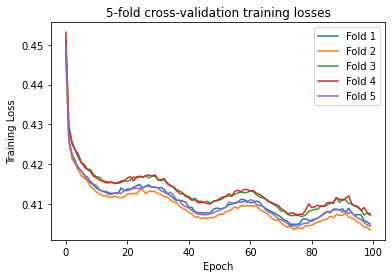

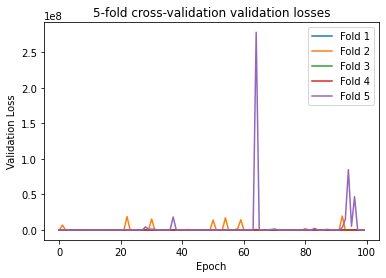

In [17]:
fig1, ax1 = plt.subplots()
for i, fold_train_loss in enumerate(L5):
    ax1.plot(fold_train_loss, label=f"Fold {i + 1}")
ax1.legend(loc='upper right')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('5-fold cross-validation training losses')


fig2, ax2 = plt.subplots()
for i, fold_val_loss in enumerate(L5_v):
    ax2.plot(fold_val_loss, label=f"Fold {i + 1}")
ax2.legend(loc='upper right')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')
ax2.set_title('5-fold cross-validation validation losses')

In [18]:
save_path = "./save/model.pth"
torch.save(model.state_dict(), save_path)

In [19]:
predictTable = pd.read_csv('./data/predict_table.csv')

In [20]:
predictTable

,product_pid,transaction_date,apply_amt_pred,redeem_amt_pred,net_in_amt_pred
0,product1,20221110,0,0,0
1,product1,20221111,0,0,0
2,product1,20221114,0,0,0
3,product1,20221115,0,0,0
4,product1,20221116,0,0,0
...,...,...,...,...,...
1385,product99,20221117,0,0,0
1386,product99,20221118,0,0,0
1387,product99,20221121,0,0,0
1388,product99,20221122,0,0,0


In [21]:
product_list = list(predictTable['product_pid'].unique())

In [22]:
predict_data = df[df['product_pid'].isin(product_list)]

In [23]:
predict_data

,product_pid,transaction_date,apply_amt,redeem_amt,net_in_amt,uv_fundown,uv_stableown,uv_fundopt,uv_fundmarket,uv_termmarket,during_days,total_net_value,yield,is_week_end,is_month_end,is_quarter_end,is_year_end,is_holiday
0,product1,2021-01-04,0.001642,0.000851,0.000791,7.918270e+05,0.0,8203723.0,0.0,0.0,0.0,NaN,0.02830,0,0,0,0,0
1,product1,2021-01-05,0.000170,0.002983,-0.002813,5.950510e+05,0.0,4432183.0,0.0,0.0,0.0,NaN,0.02840,0,0,0,0,0
2,product1,2021-01-06,0.002941,0.001342,0.001599,7.590310e+05,0.0,6924679.0,0.0,0.0,0.0,NaN,0.02800,0,0,0,0,0
3,product1,2021-01-07,0.005226,0.000000,0.005226,2.998870e+05,0.0,4399387.0,0.0,0.0,0.0,NaN,0.02740,0,0,0,0,0
4,product1,2021-01-08,0.002587,0.000000,0.002587,2.670910e+05,0.0,2333239.0,0.0,0.0,0.0,NaN,0.02740,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43394,product99,2022-11-03,6.420888,7.034544,-0.613657,1.343788e+09,428517259.0,448850779.0,1349359.0,363745159.0,90.0,4.354314,0.02055,0,0,0,0,0
43395,product99,2022-11-04,1.522984,0.000000,1.522984,1.157736e+09,366204859.0,451802419.0,1677319.0,160245979.0,90.0,4.353480,0.02085,1,0,0,0,0
43396,product99,2022-11-07,1.967026,21.100487,-19.133461,2.121512e+09,780975871.0,584462239.0,2267647.0,97441639.0,90.0,4.353897,0.02105,0,0,0,0,0
43397,product99,2022-11-08,0.874283,8.946304,-8.072022,1.165115e+09,329145379.0,407626207.0,1283767.0,37556143.0,90.0,4.352646,0.02155,0,0,0,0,0


In [24]:
predict_data['product_pid'].unique()

array(['product1', 'product100', 'product101', 'product102', 'product103',
       'product104', 'product105', 'product106', 'product107',
       'product108', 'product109', 'product110', 'product111',
       'product112', 'product113', 'product114', 'product115',
       'product116', 'product117', 'product118', 'product119',
       'product12', 'product120', 'product121', 'product122',
       'product123', 'product124', 'product125', 'product126',
       'product128', 'product129', 'product13', 'product130',
       'product131', 'product132', 'product133', 'product134',
       'product135', 'product136', 'product137', 'product138',
       'product14', 'product140', 'product141', 'product142',
       'product143', 'product144', 'product145', 'product146',
       'product147', 'product148', 'product149', 'product15',
       'product150', 'product151', 'product152', 'product153',
       'product155', 'product156', 'product157', 'product16', 'product17',
       'product19', 'product2', 'pr

In [25]:
predict_grouped = predict_data.groupby('product_pid')
predict_samples = []
product_lists = []

for product_pid, group in predict_grouped:
    
    product_lists.extend([product_pid] * 10)
    
    predict_samples.append(group.values[-30:, 2:])

In [26]:
date_list = predictTable['transaction_date'].tolist()

In [27]:
array_samples = np.array(predict_samples).astype(np.float32)

In [28]:
PREDICT_DATA = torch.tensor(array_samples, dtype=torch.float32)

In [29]:
output = model(PREDICT_DATA.to(device))

In [30]:
output = output.to('cpu')

In [31]:
predictTable

,product_pid,transaction_date,apply_amt_pred,redeem_amt_pred,net_in_amt_pred
0,product1,20221110,0,0,0
1,product1,20221111,0,0,0
2,product1,20221114,0,0,0
3,product1,20221115,0,0,0
4,product1,20221116,0,0,0
...,...,...,...,...,...
1385,product99,20221117,0,0,0
1386,product99,20221118,0,0,0
1387,product99,20221121,0,0,0
1388,product99,20221122,0,0,0


In [32]:
FINAL = output.view(1390, 2)
FINAL = pd.DataFrame(FINAL.detach().numpy(), columns = ["apply_amt_pred", "redeem_amt_pred"])

In [33]:
FINAL['net_in_amt_pred'] = FINAL['apply_amt_pred'] - FINAL['redeem_amt_pred']

In [34]:
FINAL

,apply_amt_pred,redeem_amt_pred,net_in_amt_pred
0,0.004206,-0.111540,0.115746
1,-0.017530,-0.150778,0.133248
2,-0.002541,-0.128166,0.125625
3,-0.017307,-0.037488,0.020181
4,0.017947,0.000457,0.017490
...,...,...,...
1385,0.010428,-0.027844,0.038272
1386,-0.057667,-0.013628,-0.044039
1387,0.010125,0.109658,-0.099532
1388,0.033730,0.132126,-0.098396


In [35]:
predictTable[["apply_amt_pred", "redeem_amt_pred", "net_in_amt_pred"]] = FINAL[["apply_amt_pred", "redeem_amt_pred", "net_in_amt_pred"]]

In [36]:
predictTable.to_csv("./result/predict_table.csv")